# TELECOMMUNICATION INDUSTRY
Problem to be solved: Predict which customers might leave a telecommunication provider next month.

Customer churn has many definitions: customer attrition, customer turnover, or customer defection. They are all referring to the loss of clients or customers. This can be due to voluntary reasons (by choice) or involuntary reasons (for example relocation).

Predictive analytic models can be used to predict customer churn by assessing their propensity or risk to churn. These models can generate a list of customers who are most vulnerable to churn, so that a focused customer retention program can be prioritized on them.

## The dataset
We have downloaded the customer churn dataset, WA_Fn-UseC_-Telco-Customer-Churn.csv, which contains information about 7000 customers of a telecommunication company. [Dataset source](https://www.kaggle.com/blastchar/telco-customer-churn)

Import needed libraries and open the dataset.

In [1]:
import pandas as pd   
import numpy as np    
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, fbeta_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve

In [2]:
import types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_01cc527bb96d4bf4a425a055e527cada = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='b82ZZUzL652upPKrBDIIzVcumAE--dvhoXpzzes8FBFs',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_01cc527bb96d4bf4a425a055e527cada.get_object(Bucket='mlprojectsforvariousindustries-donotdelete-pr-cswviijcwiynz0',Key='WA_Fn-UseC_-Telco-Customer-Churn.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# If you are reading an Excel file into a pandas DataFrame, replace `read_csv` by `read_excel` in the next statement.
df = pd.read_csv(body)
df.head()


customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

## Analysis of the Data and Visualizations

In [3]:
# # remove 11 rows with spaces in TotalCharges column (0.15% missing data)
# total_charges_filter = df.TotalCharges == ' '
# df = df[~total_charges_filter]  # remove rows with space in TotalCharges cell
# df.TotalCharges = pd.to_numeric(df.TotalCharges)  # convert TotalCharges column from object to float type

# remove 11 rows with spaces in TotalCharges column (0.15% missing data)
df['TotalCharges'] = df['TotalCharges'].replace(' ',np.nan)   # replace space with null field
df = df.dropna(how = 'any')   # remove all rows with any null fields 
df['TotalCharges'] = df['TotalCharges'].astype(float)  # convert TotalCharges column from object to float type

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7032 non-null object
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null object
Dependents          7032 non-null object
tenure              7032 non-null int64
PhoneService        7032 non-null object
MultipleLines       7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
Contract            7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
Churn               7032 non-null object
dtypes: float64(2), int64(2), ob

No     5163
Yes    1869
Name: Churn, dtype: int64


Text(0.5, 1.0, 'Churn')

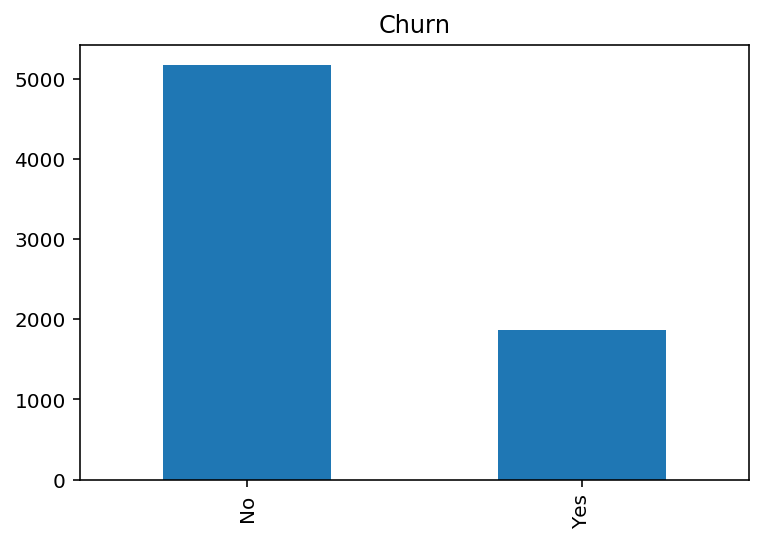

In [4]:
# Target variable distribution is not balanced as there are more non-churned than churned users
print(df.Churn.value_counts())
df['Churn'].value_counts().plot('bar').set_title('Churn')

In [5]:
# percentage of churn customers
1869/(5163+1869)

0.26578498293515357

In this dataset of over 7000 customers, 26% of them has left in the last month. This is critical to business because it is often more expensive to acquire new customers than to keep existing ones.

In [6]:
# see all numerical columns
df.describe()

SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7032.000000  7032.000000     7032.000000   7032.000000
mean        0.162400    32.421786       64.798208   2283.300441
std         0.368844    24.545260       30.085974   2266.771362
min         0.000000     1.000000       18.250000     18.800000
25%         0.000000     9.000000       35.587500    401.450000
50%         0.000000    29.000000       70.350000   1397.475000
75%         0.000000    55.000000       89.862500   3794.737500
max         1.000000    72.000000      118.750000   8684.800000

The features in this dataset include the following:

- **customer demographic data**: Gender, SeniorCitizen, Partner, Dependents

- **subscribed services**: PhoneService, MultipleLine, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies

- **customer account information**: CustomerID, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Tenure

Target is Churn, which has binary classes 1 and 0.

In [7]:
# replace values for SeniorCitizen as a categorical feature
df['SeniorCitizen'] = df['SeniorCitizen'].replace({1:'Yes',0:'No'})

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[num_cols].describe()

tenure  MonthlyCharges  TotalCharges
count  7032.000000     7032.000000   7032.000000
mean     32.421786       64.798208   2283.300441
std      24.545260       30.085974   2266.771362
min       1.000000       18.250000     18.800000
25%       9.000000       35.587500    401.450000
50%      29.000000       70.350000   1397.475000
75%      55.000000       89.862500   3794.737500
max      72.000000      118.750000   8684.800000

Next is feature engineering. These 3 features Tenure, Monthly Charges and Total Charges are continuous data to be split into categories. When I looked at the pair plot, it seems possible to separate the churn and non-churn customers.

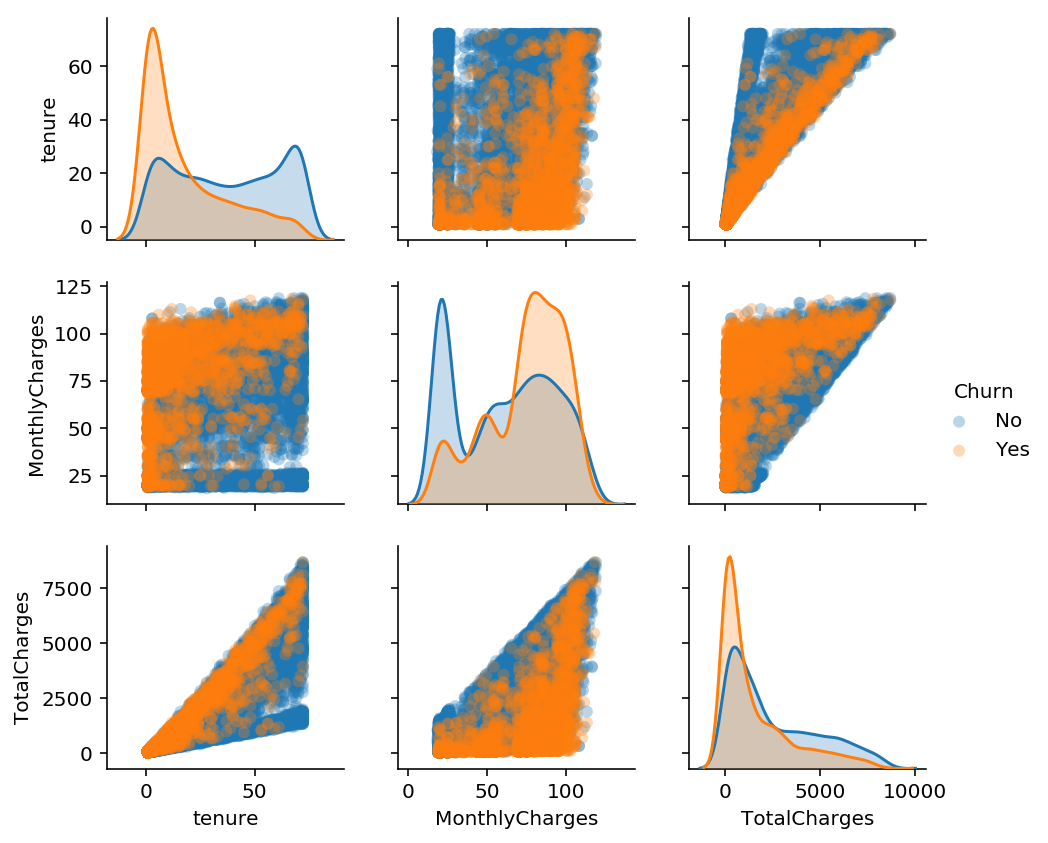

In [8]:
sns.pairplot(df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']], 
             hue='Churn', plot_kws=dict(alpha=.3, edgecolor='none'), height=2, aspect=1.1);

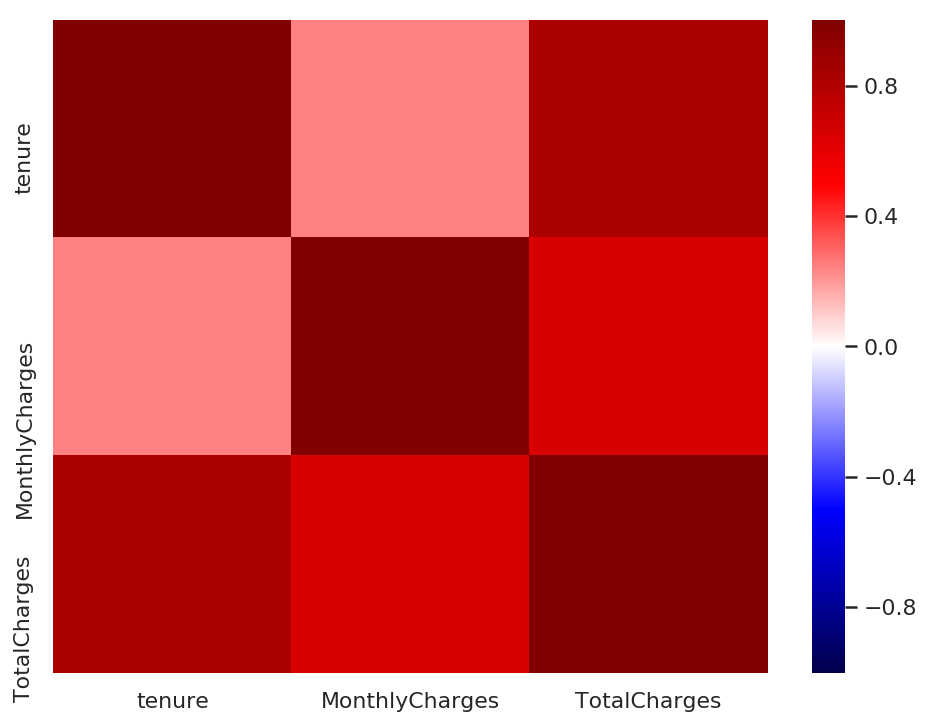

In [9]:
# Correlation Matrix for variables
sns.set(rc={'figure.figsize':(8,6)})
sns.heatmap(df.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7f88402470>,
      dtype=object)

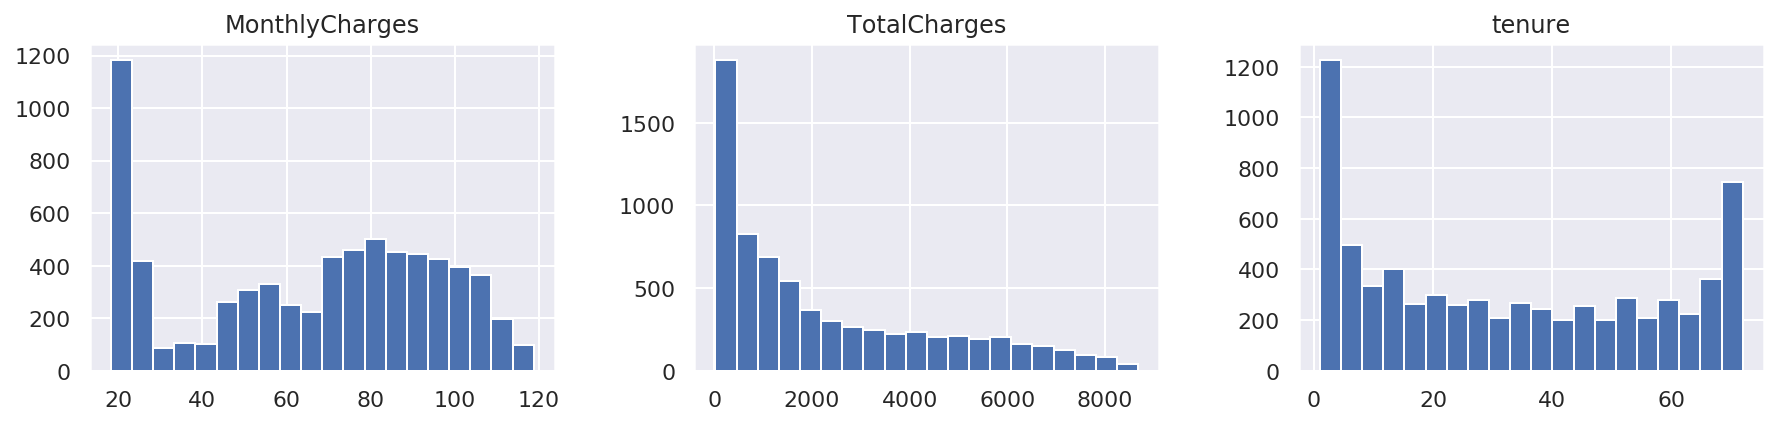

In [10]:
# to view numerical features in charts
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
df[num_cols].hist(bins=20, figsize=(10, 7), ax=ax)

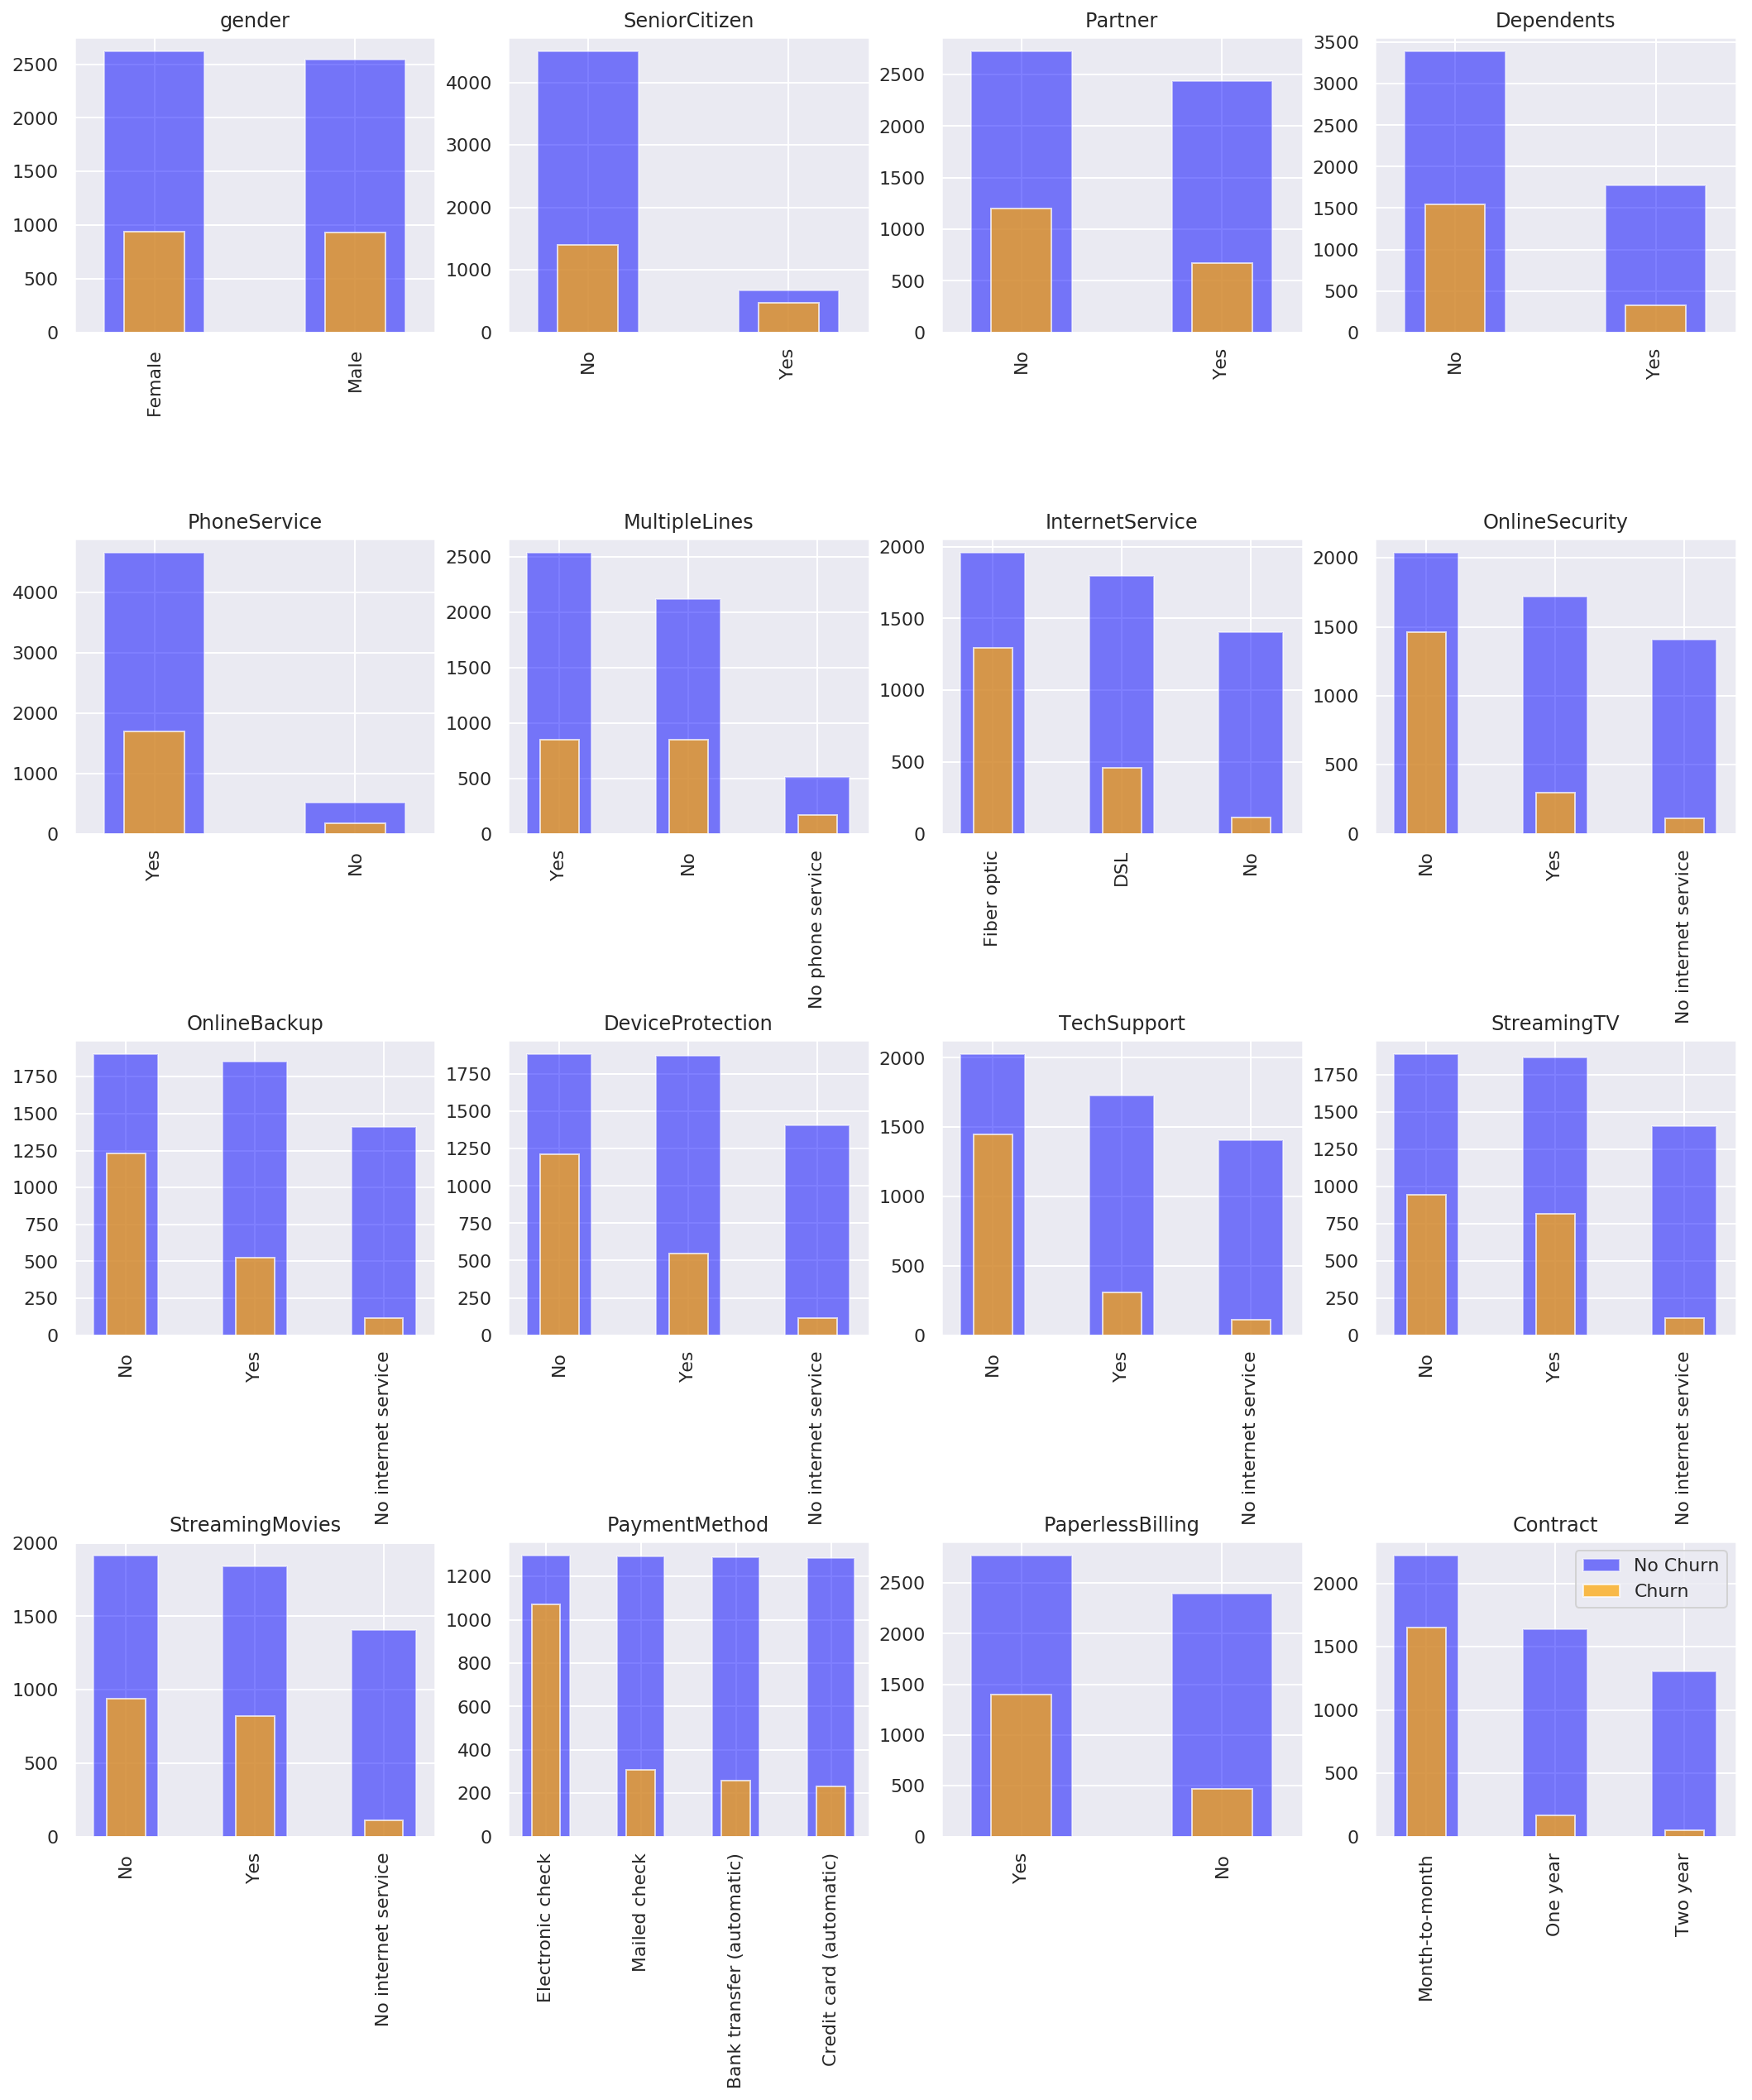

In [11]:
# To analyse categorical feature distribution
# Note: senior citizens and customers without phone service are minority (less represented) in the data
# Note: "No Internet Service" is a repeated feature in 6 other charts

categorical_features = [
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'PaymentMethod',
 'PaperlessBilling',
 'Contract' ]

ROWS, COLS = 4, 4
fig, ax = plt.subplots(ROWS, COLS, figsize=(18, 20) )
row, col = 0, 0
for i, categorical_feature in enumerate(categorical_features):
    if col == COLS - 1:
        row += 1
    col = i % COLS
#     df[categorical_feature].value_counts().plot('bar', ax=ax[row, col]).set_title(categorical_feature)
    df[df.Churn=='No'][categorical_feature].value_counts().plot('bar', 
                width=.5, ax=ax[row, col], color='blue', alpha=0.5).set_title(categorical_feature)
    df[df.Churn=='Yes'][categorical_feature].value_counts().plot('bar', 
                width=.3, ax=ax[row, col], color='orange', alpha=0.7).set_title(categorical_feature)
    plt.legend(['No Churn', 'Churn'])
    fig.subplots_adjust(hspace=0.7)

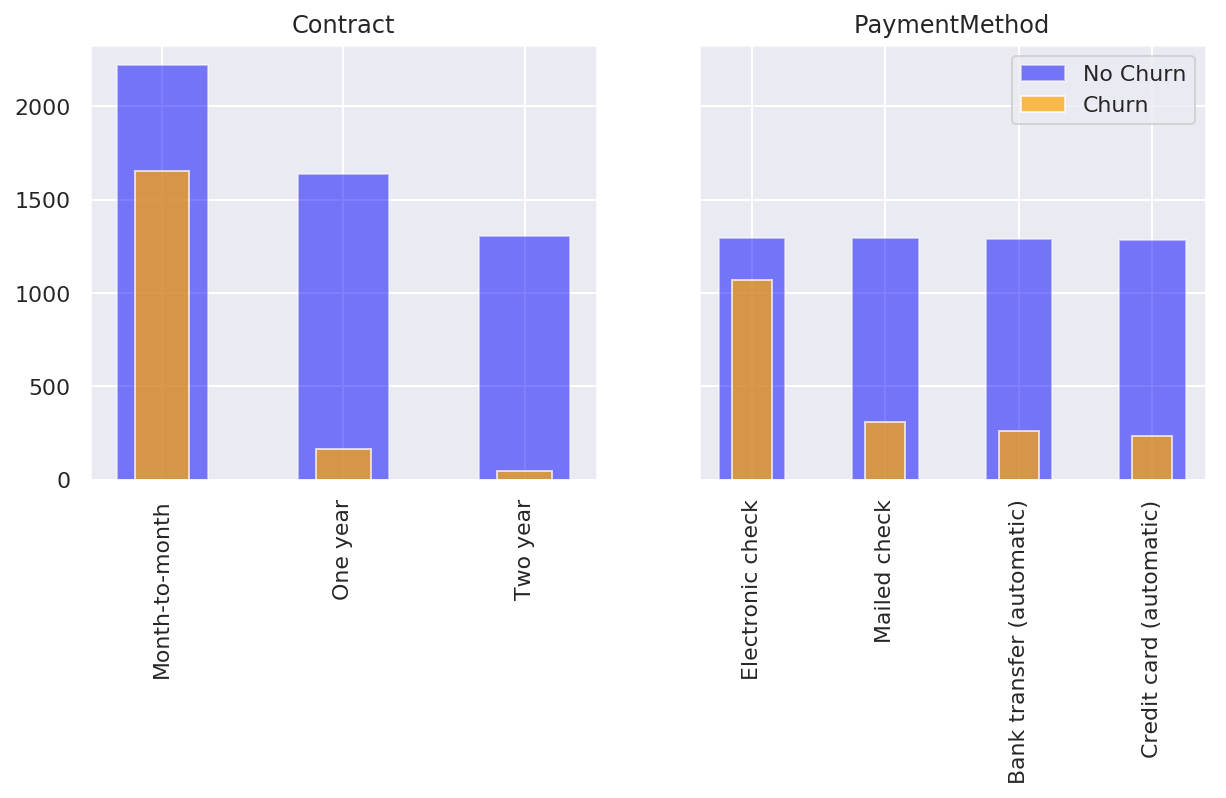

In [12]:
# to look at Contract & Payment Method in relation to the target variable
# note: users who have a month-to-month contract and Electronic check PaymentMethod are more likely to churn
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
df[df.Churn == 'No']['Contract'].value_counts().plot('bar', ax=ax[0], color='blue', alpha=0.5).set_title('Contract')
df[df.Churn == 'Yes']['Contract'].value_counts().plot('bar', width=.3, ax=ax[0], color='orange', alpha=0.7)
df[df.Churn == 'No']['PaymentMethod'].value_counts().plot('bar', ax=ax[1], color='blue', alpha=0.5).set_title('PaymentMethod')
df[df.Churn == 'Yes']['PaymentMethod'].value_counts().plot('bar', width=.3, ax=ax[1], color='orange', alpha=0.7)
plt.legend(['No Churn', 'Churn'])

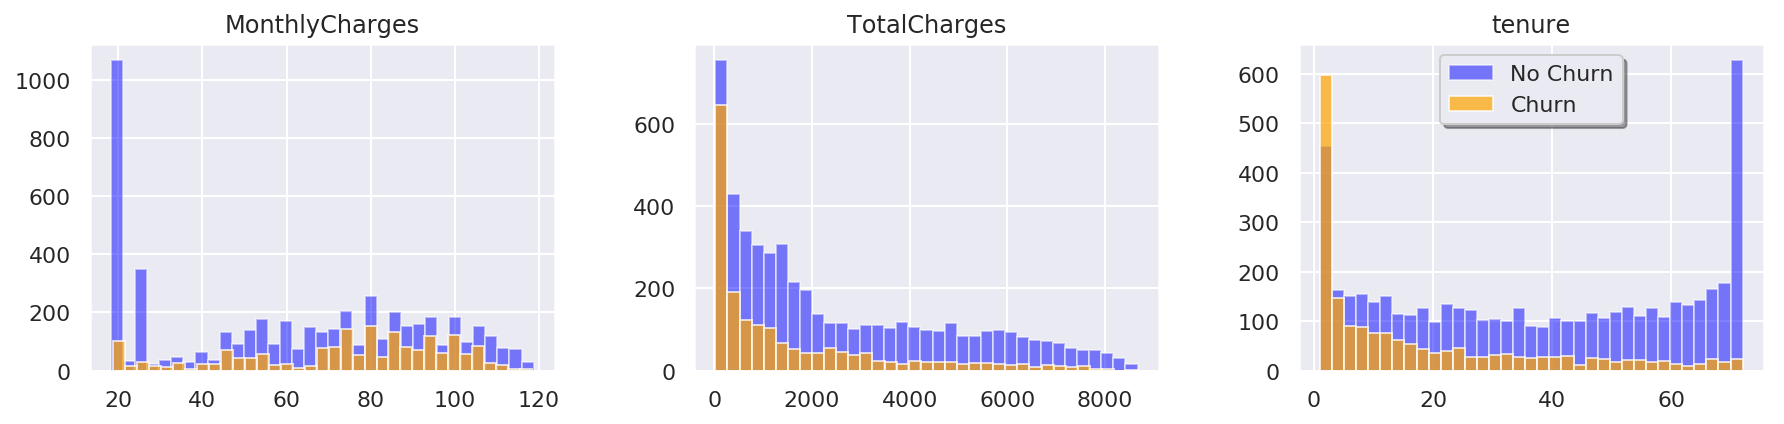

In [13]:
# look at distributions of numerical features in relation to the target variable
# the greater TotalCharges and tenure are the less is the probability of churn

fig, ax = plt.subplots(1, 3, figsize=(15, 3))
df[df.Churn == "No"][num_cols].hist(bins=35, color="blue", alpha=0.5, ax=ax)
df[df.Churn == "Yes"][num_cols].hist(bins=35, color="orange", alpha=0.7, ax=ax)
plt.legend(['No Churn', 'Churn'], shadow=True, loc=9)

## Feature Engineering

In [14]:
# change MonthlyCharges to categorical column
def monthlycharges_split(df) :   
    if df['MonthlyCharges'] <= 30 :
        return '0-30'
    elif (df['MonthlyCharges'] > 30) & (df['MonthlyCharges'] <= 70 ):
        return '30-70'
    elif (df['MonthlyCharges'] > 70) & (df['MonthlyCharges'] <= 99 ):
        return '70-99'
    elif df['MonthlyCharges'] > 99 :
        return '99plus'
df['monthlycharges_group'] = df.apply(lambda df:monthlycharges_split(df), axis = 1)

# change TotalCharges to categorical column
def totalcharges_split(df) :   
    if df['TotalCharges'] <= 2000 :
        return '0-2k'
    elif (df['TotalCharges'] > 2000) & (df['TotalCharges'] <= 4000 ):
        return '2k-4k'
    elif (df['TotalCharges'] > 4000) & (df['TotalCharges'] <= 6000) :
        return '4k-6k'
    elif df['TotalCharges'] > 6000 :
        return '6kplus'
df['totalcharges_group'] = df.apply(lambda df:totalcharges_split(df), axis = 1)

# change Tenure to categorical column
def tenure_split(df) :   
    if df['tenure'] <= 20 :
        return '0-20'
    elif (df['tenure'] > 20) & (df['tenure'] <= 40 ):
        return '20-40'
    elif (df['tenure'] > 40) & (df['tenure'] <= 60) :
        return '40-60'
    elif df['tenure'] > 60 :
        return '60plus'
df['tenure_group'] = df.apply(lambda df:tenure_split(df), axis = 1)

# # Separating categorical and numerical columns
# Id_col     = ['customerID']
# target_col = ['Churn']
# cat_cols   = df.nunique()[df.nunique() < 6].keys().tolist()
# cat_cols   = [x for x in cat_cols if x not in target_col]
# num_cols   = [x for x in df.columns if x not in cat_cols + target_col + Id_col]

# target_col

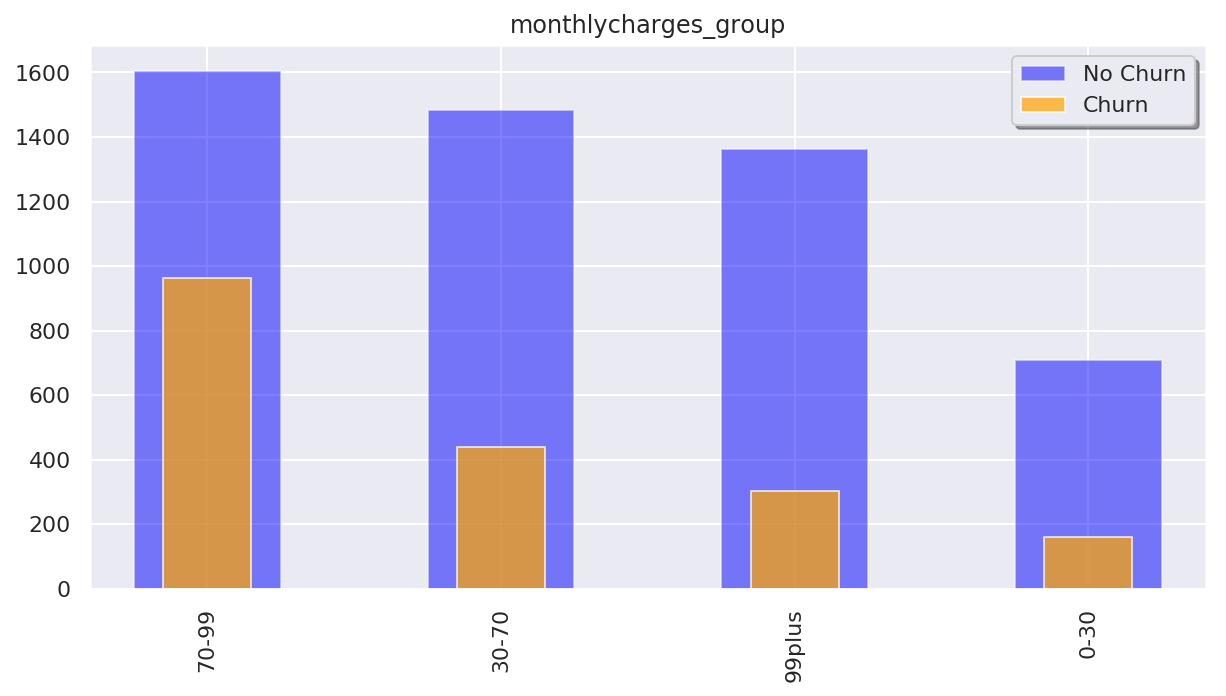

In [15]:
# new features monthlycharges_group
plt.figure(figsize = [10,5])
df[df.Churn == "No"]['monthlycharges_group'].value_counts().plot('bar', color="blue", alpha=0.5).set_title('monthlycharges_group')
df[df.Churn == "Yes"]['monthlycharges_group'].value_counts().plot('bar', color="orange", alpha=0.7, width=0.3)
plt.legend(['No Churn', 'Churn'], shadow=True, loc=1)

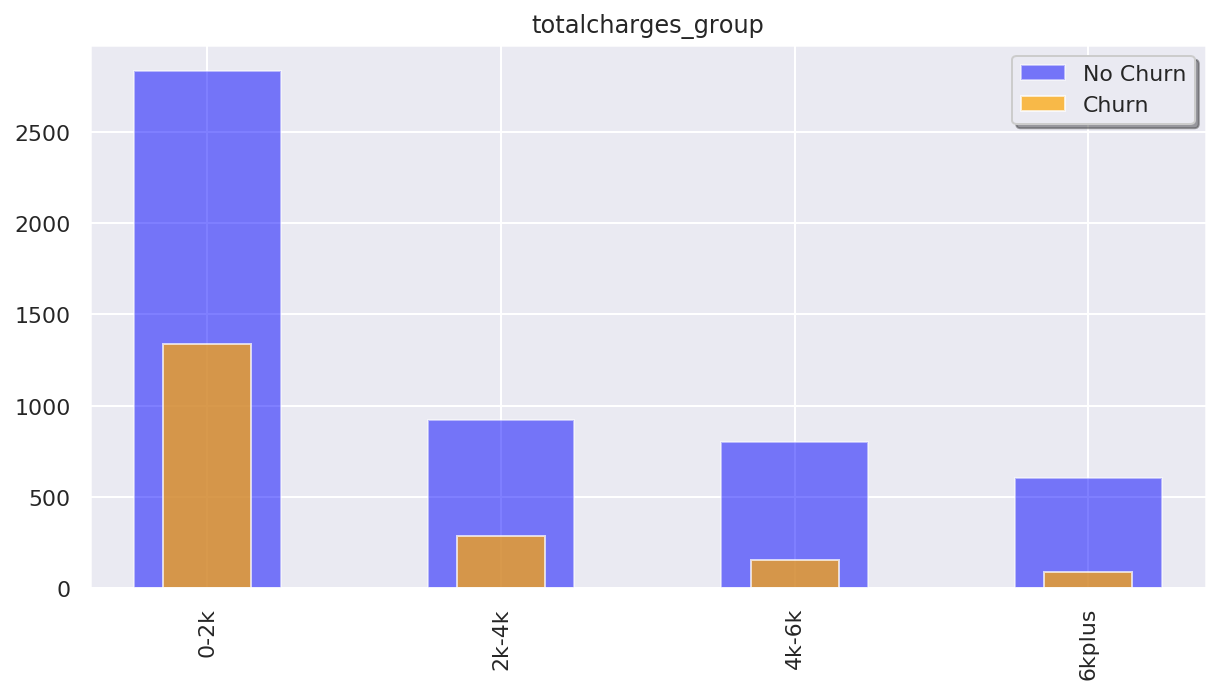

In [17]:
# new features totalcharges_group
plt.figure(figsize = [10,5])
df[df.Churn == "No"]['totalcharges_group'].value_counts().plot('bar', color="blue", alpha=0.5).set_title('totalcharges_group')
df[df.Churn == "Yes"]['totalcharges_group'].value_counts().plot('bar', color="orange", alpha=0.7, width=0.3)
plt.legend(['No Churn', 'Churn'], shadow=True, loc=1)

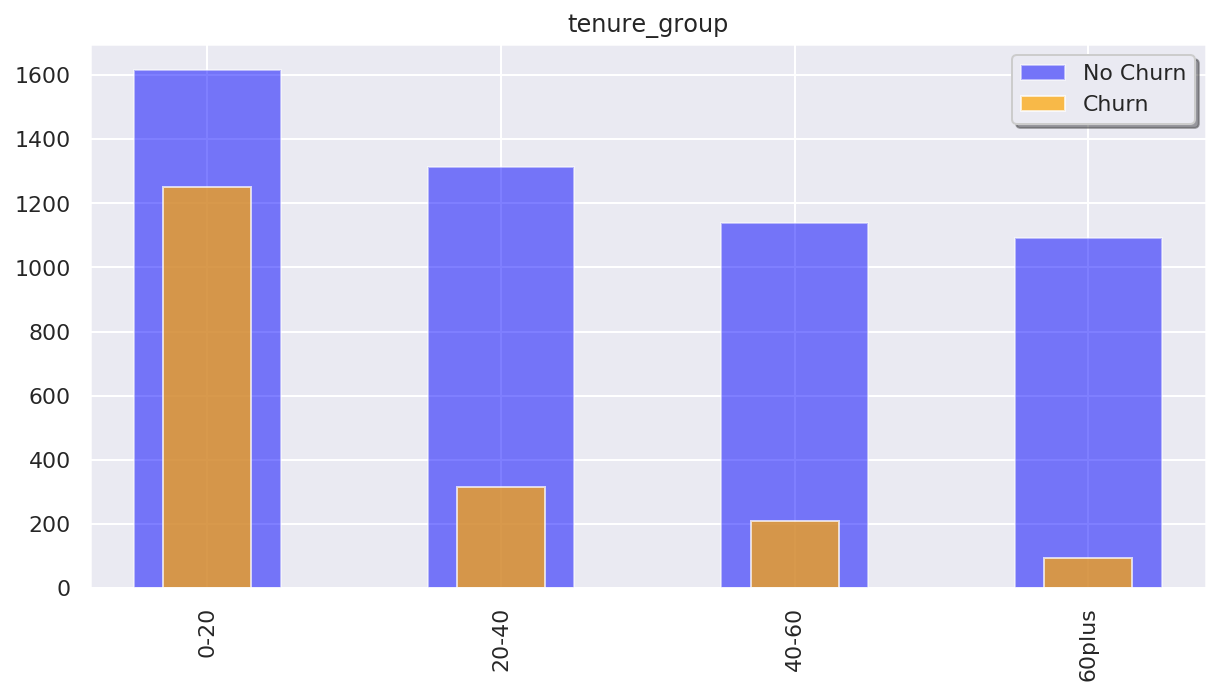

In [18]:
# new features tenure_group
plt.figure(figsize = [10,5])
df[df.Churn == "No"]['tenure_group'].value_counts().plot('bar', color="blue", alpha=0.5).set_title('tenure_group')
df[df.Churn == "Yes"]['tenure_group'].value_counts().plot('bar', color="orange", alpha=0.7, width=0.3)
plt.legend(['No Churn', 'Churn'], shadow=True, loc=1)

In [19]:
# store df to csv file
df.to_csv('df.csv', index=False)

# # backup original df for reference
# df_telcom_org = df.copy()   
# df_telcom_org

In [20]:
df = pd.read_csv('df.csv')

## Data preprocessing

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# customer id col
Id_col     = ['customerID']
# Target columns
target_col = ['Churn']
#categorical columns
cat_cols   = df.nunique()[df.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols   = [x for x in df.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols   = df.nunique()[df.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    df[i] = le.fit_transform(df[i])
    
#Duplicating columns for multi value columns
df = pd.get_dummies(data = df, columns = multi_cols)

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df1 = df.drop(columns = num_cols, axis = 1)
df1 = df1.merge(scaled, left_index=True, right_index=True, how = "left")

# note: df has 21 columns including unscaled num_cols; df1 has 54 columns including scaled num_cols
# I defined 2 separate df & df1 for comparison, to check if the columns are correctly labelled after encoding/get_dummies

In [22]:
# check if there is any null fields (ie, ensure all fields are filled)
df1[df1.TotalCharges.isnull()]

Empty DataFrame
Columns: [customerID, gender, SeniorCitizen, Partner, Dependents, PhoneService, PaperlessBilling, Churn, MultipleLines_No, MultipleLines_No phone service, MultipleLines_Yes, InternetService_DSL, InternetService_Fiber optic, InternetService_No, OnlineSecurity_No, OnlineSecurity_No internet service, OnlineSecurity_Yes, OnlineBackup_No, OnlineBackup_No internet service, OnlineBackup_Yes, DeviceProtection_No, DeviceProtection_No internet service, DeviceProtection_Yes, TechSupport_No, TechSupport_No internet service, TechSupport_Yes, StreamingTV_No, StreamingTV_No internet service, StreamingTV_Yes, StreamingMovies_No, StreamingMovies_No internet service, StreamingMovies_Yes, Contract_Month-to-month, Contract_One year, Contract_Two year, PaymentMethod_Bank transfer (automatic), PaymentMethod_Credit card (automatic), PaymentMethod_Electronic check, PaymentMethod_Mailed check, monthlycharges_group_0-30, monthlycharges_group_30-70, monthlycharges_group_70-99, monthlycharges_group_99plus, totalcharges_group_0-2k, totalcharges_group_2k-4k, totalcharges_group_4k-6k, totalcharges_group_6kplus, tenure_group_0-20, tenure_group_20-40, tenure_group_40-60, tenure_group_60plus, tenure, MonthlyCharges, TotalCharges]
Index: []

[0 rows x 54 columns]

In [23]:
df1.describe()

gender  SeniorCitizen      Partner   Dependents  PhoneService  \
count  7032.000000    7032.000000  7032.000000  7032.000000   7032.000000   
mean      0.504693       0.162400     0.482509     0.298493      0.903299   
std       0.500014       0.368844     0.499729     0.457629      0.295571   
min       0.000000       0.000000     0.000000     0.000000      0.000000   
25%       0.000000       0.000000     0.000000     0.000000      1.000000   
50%       1.000000       0.000000     0.000000     0.000000      1.000000   
75%       1.000000       0.000000     1.000000     1.000000      1.000000   
max       1.000000       1.000000     1.000000     1.000000      1.000000   

       PaperlessBilling        Churn  MultipleLines_No  \
count       7032.000000  7032.000000       7032.000000   
mean           0.592719     0.265785          0.481371   
std            0.491363     0.441782          0.499688   
min            0.000000     0.000000          0.000000   
25%            0.000000     0.000000          0.000000   
50%            1.000000     0.000000          0.000000   
75%            1.000000     1.000000          1.000000   
max            1.000000     1.000000          1.000000   

       MultipleLines_No phone service  MultipleLines_Yes  ...  \
count                     7032.000000        7032.000000  ...   
mean                         0.096701           0.421928  ...   
std                          0.295571           0.493902  ...   
min                          0.000000           0.000000  ...   
25%                          0.000000           0.000000  ...   
50%                          0.000000           0.000000  ...   
75%                          0.000000           1.000000  ...   
max                          1.000000           1.000000  ...   

       totalcharges_group_2k-4k  totalcharges_group_4k-6k  \
count               7032.000000                7032.00000   
mean                   0.171786                   0.13595   
std                    0.377221                   0.34276   
min                    0.000000                   0.00000   
25%                    0.000000                   0.00000   
50%                    0.000000                   0.00000   
75%                    0.000000                   0.00000   
max                    1.000000                   1.00000   

       totalcharges_group_6kplus  tenure_group_0-20  tenure_group_20-40  \
count                7032.000000        7032.000000         7032.000000   
mean                    0.098407           0.407708            0.200228   
std                     0.297886           0.491443            0.400199   
min                     0.000000           0.000000            0.000000   
25%                     0.000000           0.000000            0.000000   
50%                     0.000000           0.000000            0.000000   
75%                     0.000000           1.000000            0.000000   
max                     1.000000           1.000000            1.000000   

       tenure_group_40-60  tenure_group_60plus        tenure  MonthlyCharges  \
count         7032.000000          7032.000000  7.032000e+03    7.032000e+03   
mean             0.191980             0.200085 -1.214741e-16    9.652878e-17   
std              0.393885             0.400092  1.000071e+00    1.000071e+00   
min              0.000000             0.000000 -1.280248e+00   -1.547283e+00   
25%              0.000000             0.000000 -9.542963e-01   -9.709769e-01   
50%              0.000000             0.000000 -1.394171e-01    1.845440e-01   
75%              0.000000             0.000000  9.199259e-01    8.331482e-01   
max              1.000000             1.000000  1.612573e+00    1.793381e+00   

       TotalCharges  
count  7.032000e+03  
mean  -1.172113e-16  
std    1.000071e+00  
min   -9.990692e-01  
25%   -8.302488e-01  
50%   -3.908151e-01  
75%    6.668271e-01  
max    2.824261e+00  

[8 rows x 53 columns]

In [24]:
df1.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'PaperlessBilling', 'Churn', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'P

In [25]:
df1.dtypes

customerID                                  object
gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
PhoneService                                 int64
PaperlessBilling                             int64
Churn                                        int64
MultipleLines_No                             uint8
MultipleLines_No phone service               uint8
MultipleLines_Yes                            uint8
InternetService_DSL                          uint8
InternetService_Fiber optic                  uint8
InternetService_No                           uint8
OnlineSecurity_No                            uint8
OnlineSecurity_No internet service           uint8
OnlineSecurity_Yes                           uint8
OnlineBackup_No                              uint8
OnlineBackup_No internet service             uint8
OnlineBackup_Yes               

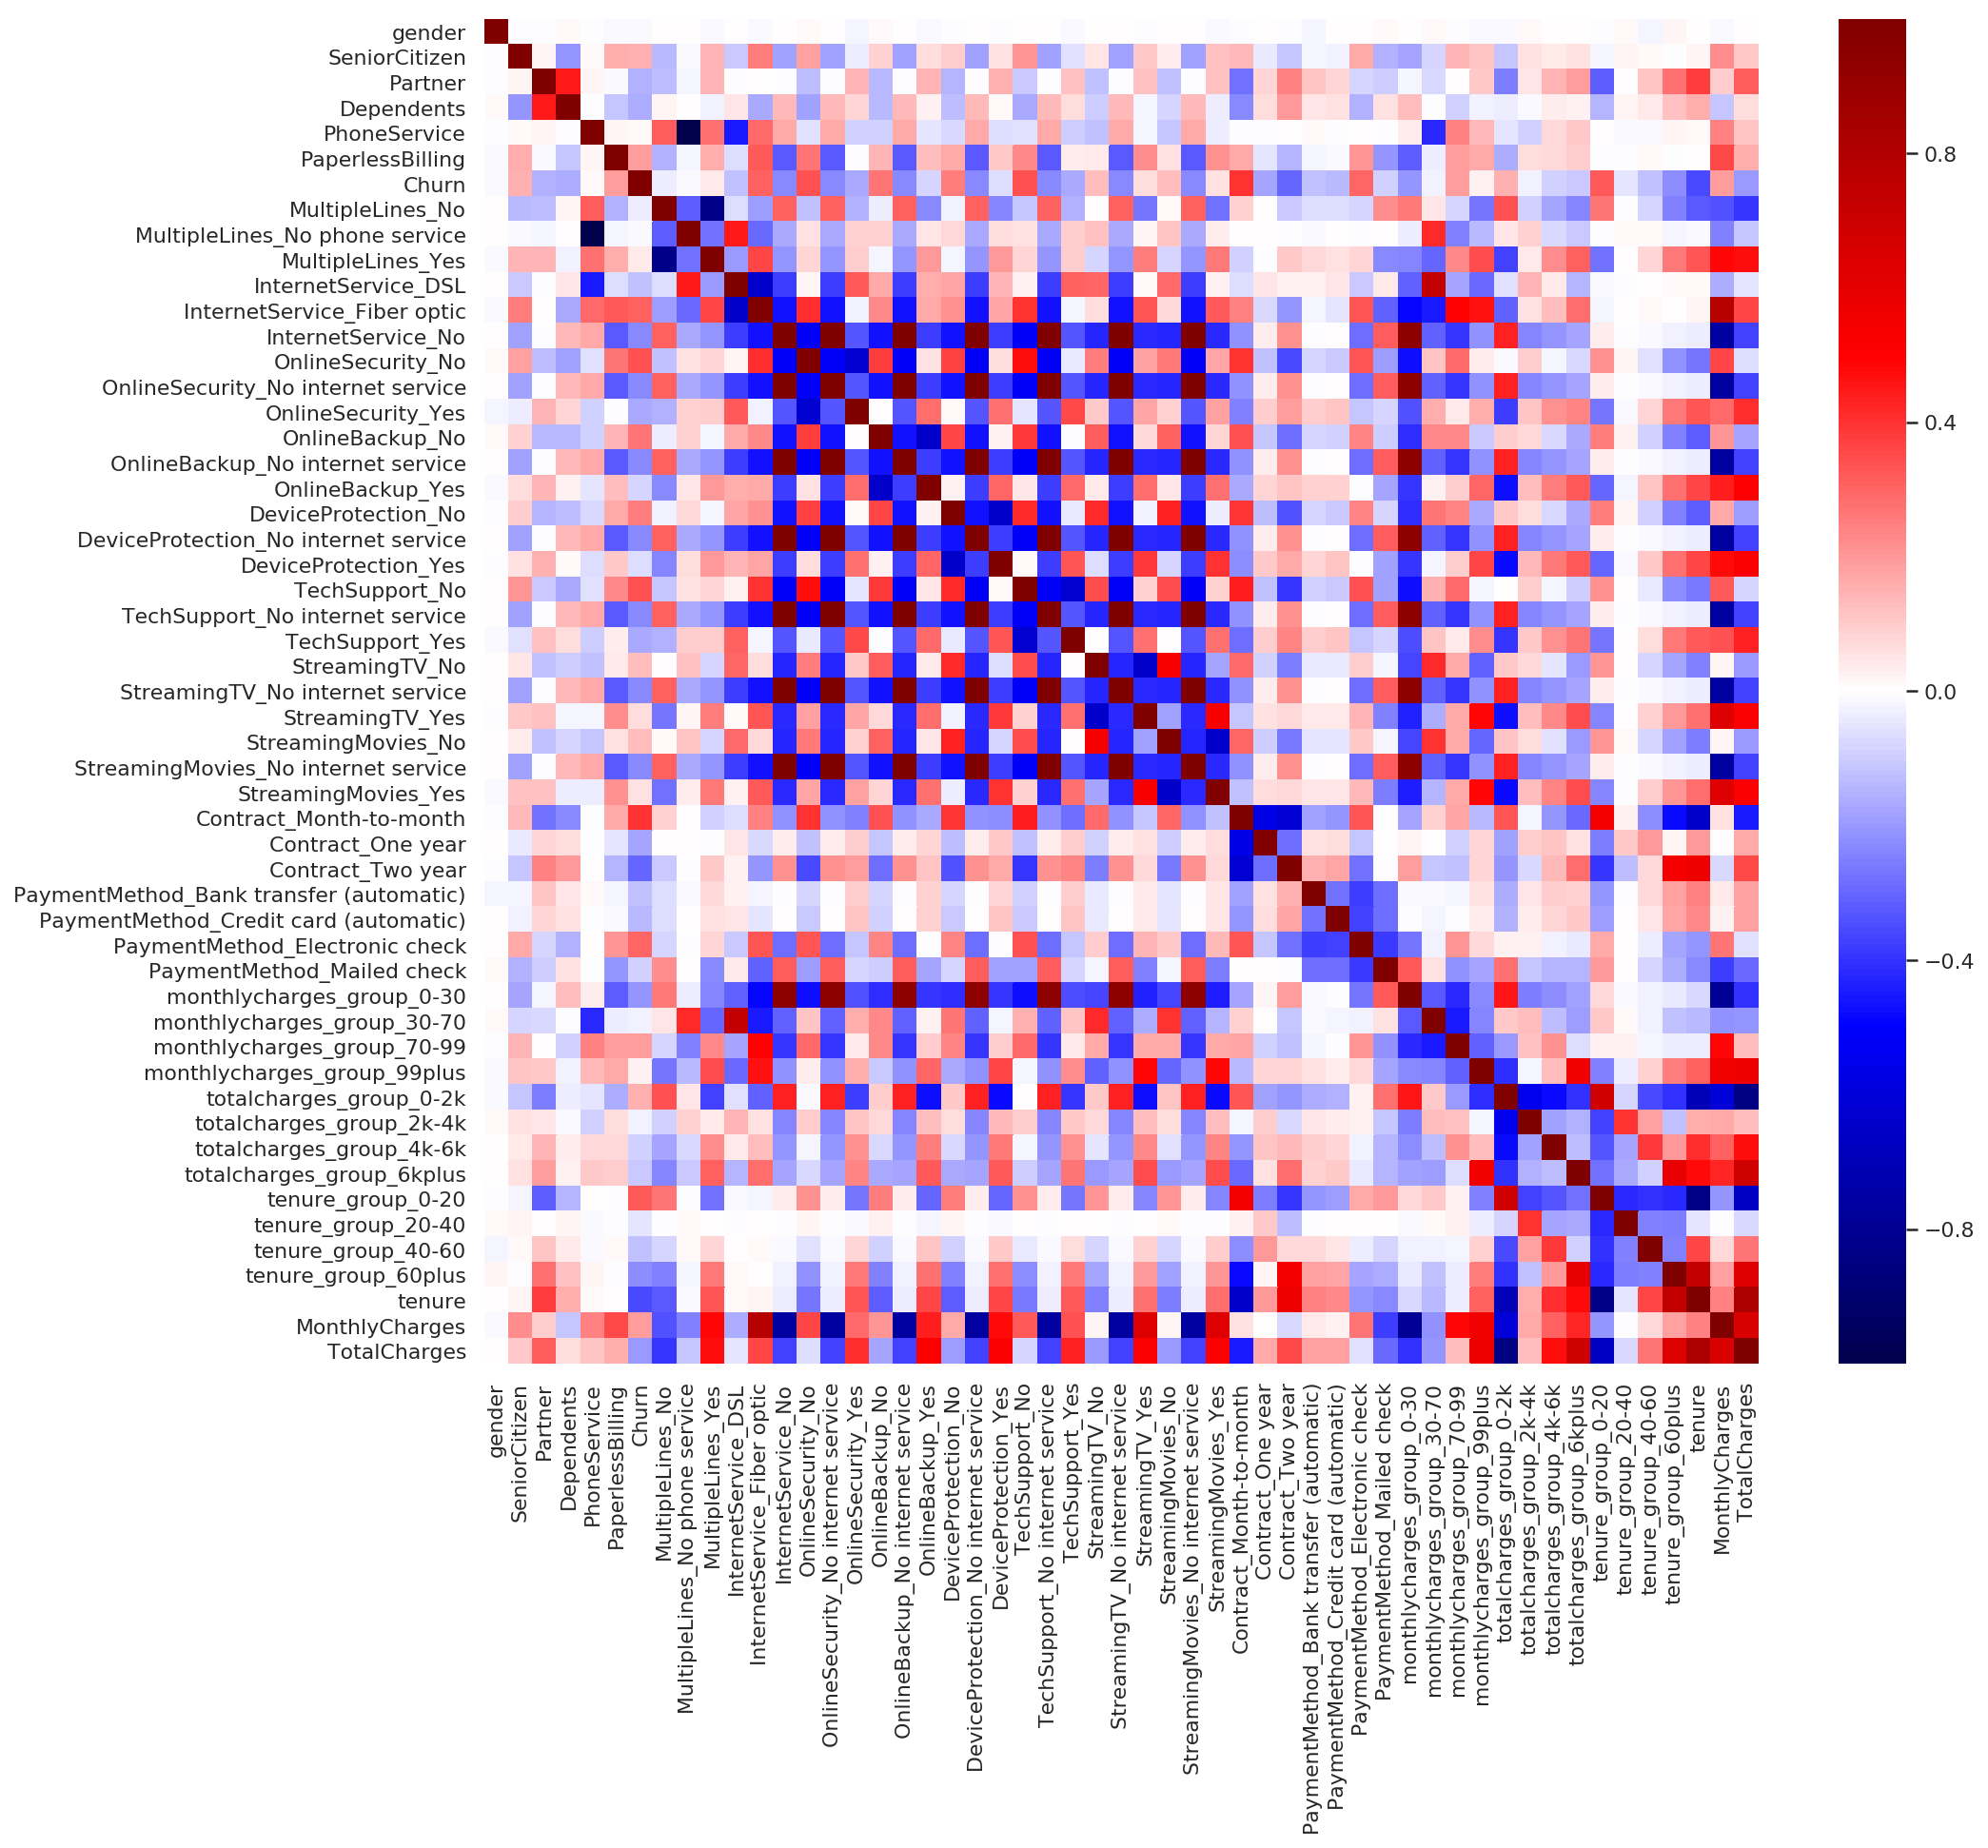

In [26]:
# Correlation Matrix for variables
sns.set(rc={'figure.figsize':(15,13)})
sns.heatmap(df1.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1)

In [27]:
# drop 'customerID' column, feature not needed in model selection
df1 = df1.drop('customerID', axis=1)

# there are a lot of repeated features (no internet service), so drop them
df1 = df1.drop(columns=['OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 
                        'DeviceProtection_No internet service', 'TechSupport_No internet service', 
                        'StreamingTV_No internet service', 'StreamingMovies_No internet service'], axis=1)

# original 54 columns, reduced to 47 columns

In [28]:
df1.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'PaperlessBilling', 'Churn', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_Yes', 'StreamingMovies_No',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'monthlycharges_group_0-30', 'monthlycharges_group_30-70',
       'monthlycharges_group_70-99', 'monthlycharges_group_99plus',
       'totalcharges_group_0-2k', 'totalcharges_group_2k-4k',
       

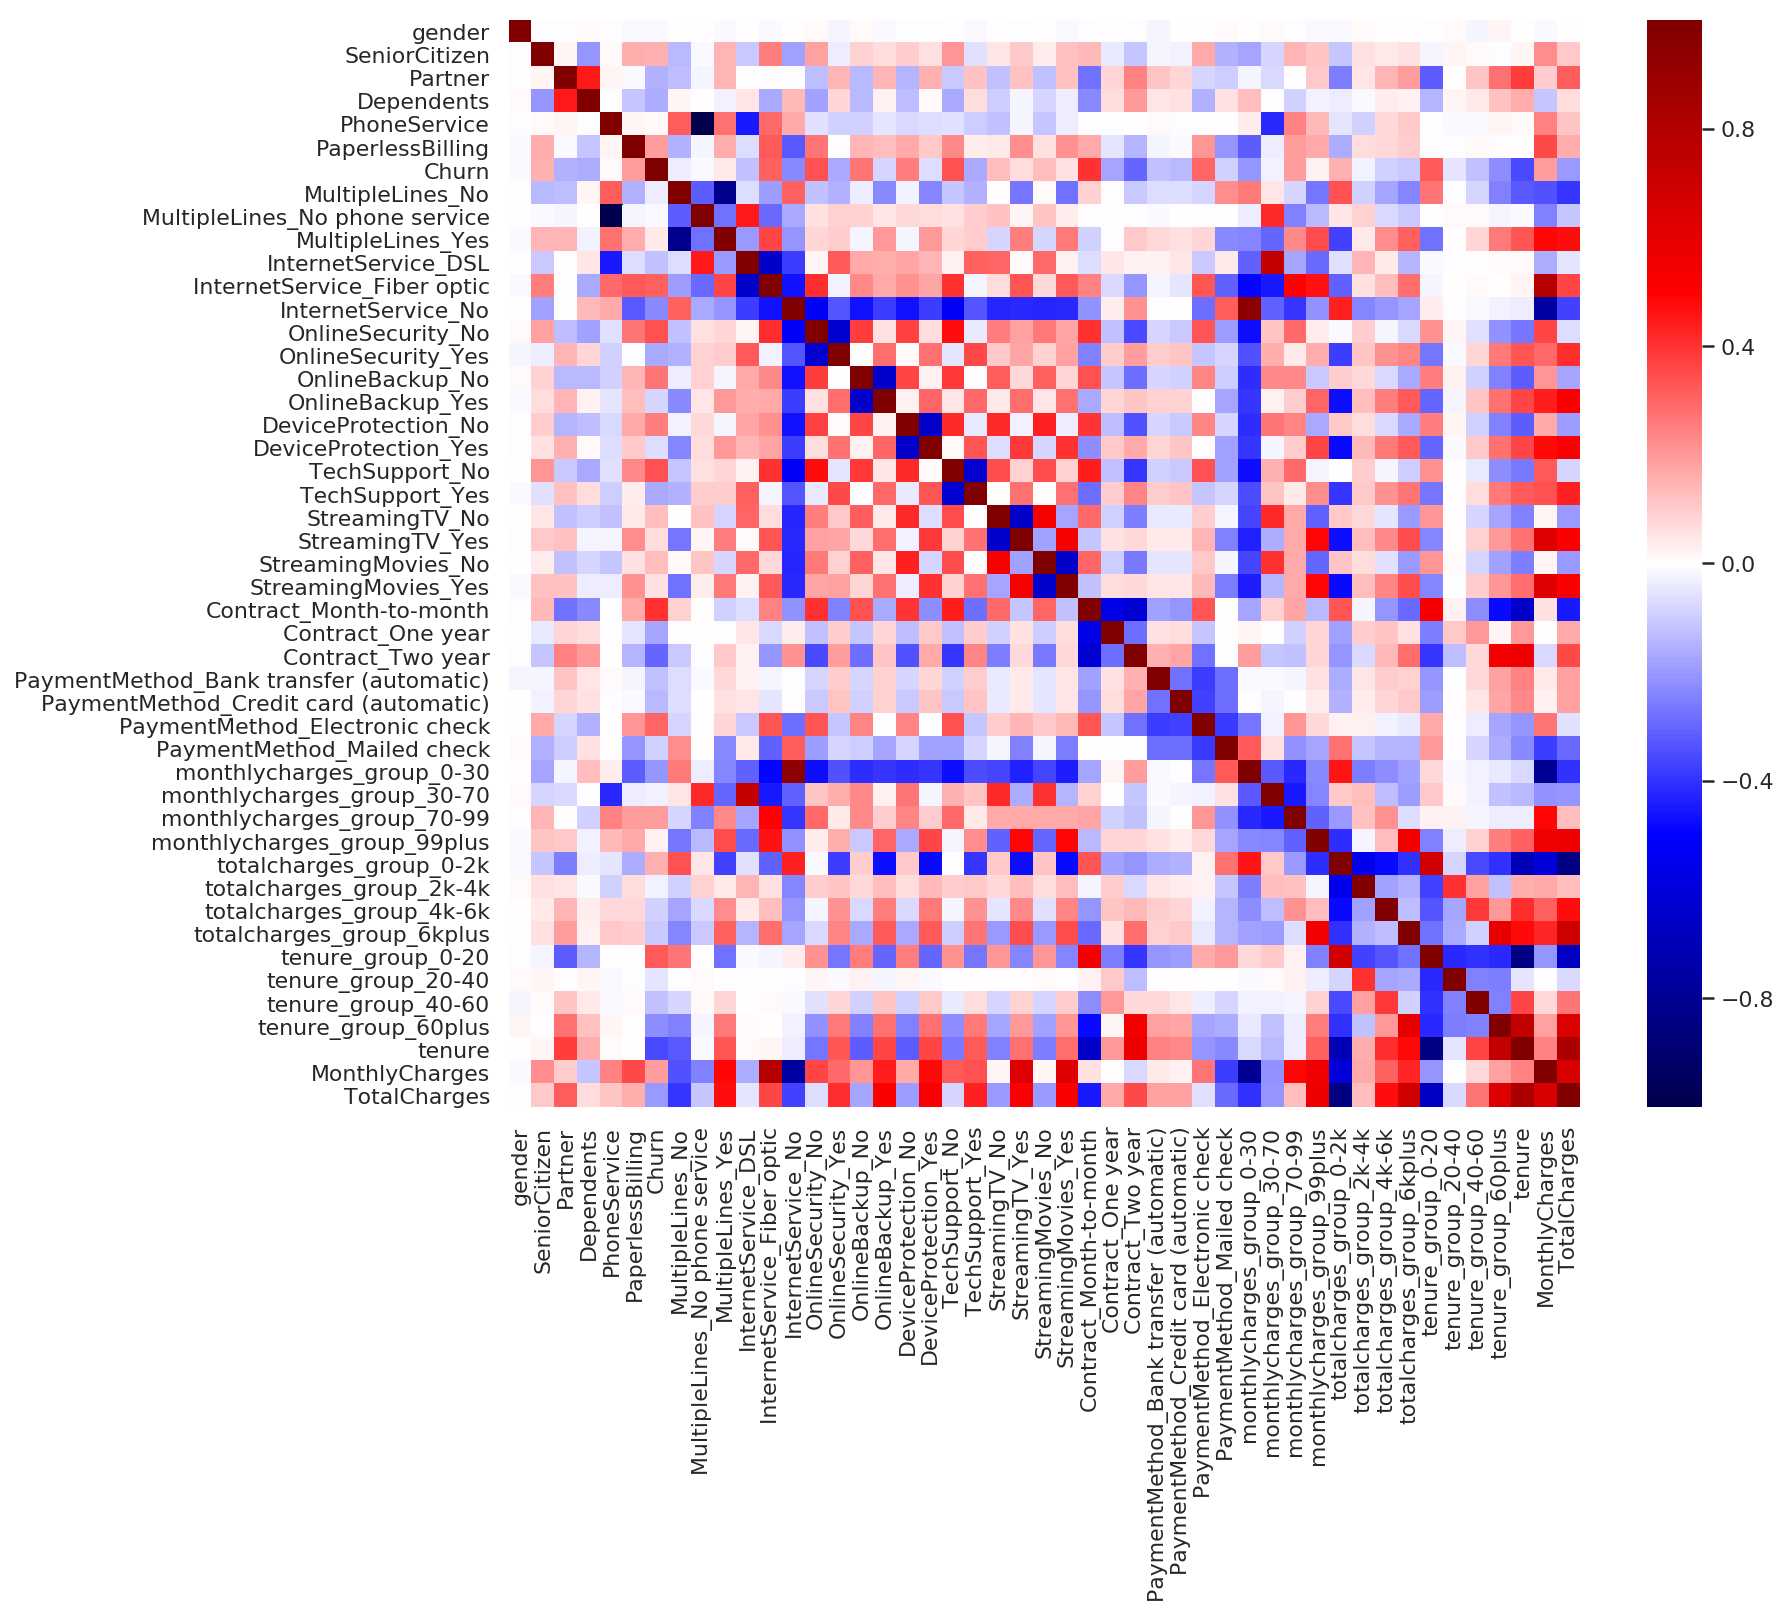

In [29]:
# Correlation Matrix for variables
sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(df1.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1)

In [30]:
# store df1 to csv file
df1.to_csv('df1.csv', index=False)

## Feature Selection
Features are selected mainly based on **Lasso** coefficient. I have also considered the p-values and coefficients from **Statsmodels**, and looped through dropping features one by one to measure its impact on model performance.

In [31]:
df1 = pd.read_csv('df1.csv')

In [32]:
X, y = df1.drop('Churn',axis=1), df1[['Churn']]

import statsmodels.api as sm
X = sm.add_constant(X)  # need to add this to define the Intercept
# model / fit / summarize results
model = sm.OLS(y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Churn   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     92.94
Date:                Wed, 27 May 2020   Prob (F-statistic):               0.00
Time:                        10:45:30   Log-Likelihood:                -2987.7
No. Observations:                7032   AIC:                             6041.
Df Residuals:                    6999   BIC:                             6268.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       0.0244      0.051      0.479      0.632      -0.076       0.124
gender                                     -0.0042      0.009     -0.478      0.633      -0.022       0.013
SeniorCitizen                               0.0462      0.013      3.582      0.000       0.021       0.071
Partner                                     0.0032      0.011      0.295      0.768      -0.018       0.024
Dependents                                 -0.0169      0.011     -1.487      0.137      -0.039       0.005
PhoneService                                0.0256      0.020      1.281      0.200      -0.014       0.065
PaperlessBilling                            0.0432      0.010      4.365      0.000       0.024       0.063
MultipleLines_No                           -0.0205      0.006     -3.386      0.001      -0.032      -0.009
MultipleLines_No phone service             -0.0012      0.070     -0.018      0.986      -0.139       0.136
MultipleLines_Yes                           0.0461      0.021      2.157      0.031       0.004       0.088
InternetService_DSL                        -0.0639      0.033     -1.947      0.052      -0.128       0.000
InternetService_Fiber optic                 0.1441      0.076      1.886      0.059      -0.006       0.294
InternetService_No                         -0.0557      0.095     -0.584      0.559      -0.243       0.131
OnlineSecurity_No                           0.0578      0.013      4.442      0.000       0.032       0.083
OnlineSecurity_Yes                          0.0223      0.034      0.662      0.508      -0.044       0.088
OnlineBackup_No                             0.0451      0.013      3.491      0.000       0.020       0.070
OnlineBackup_Yes                            0.0350      0.034      1.042      0.297      -0.031       0.101
DeviceProtection_No                         0.0367      0.013      2.825      0.005       0.011       0.062
DeviceProtection_Yes                        0.0434      0.034      1.290      0.197      -0.023       0.109
TechSupport_No                              0.0582      0.013      4.441      0.000       0.033       0.084
TechSupport_Yes                             0.0219      0.034      0.651      0.515      -0.044       0.088
StreamingTV_No                              0.0065      0.007      0.965      0.335      -0.007       0.020
StreamingTV_Yes                             0.0736      0.044      1.666      0.096      -0.013       0.160
StreamingMovies_No                          0.0072      0.007      1.070      0.285      -0.006       0.020
StreamingMovies_Yes                         0.0729      0.044      1.650      0.099      -0.014       0.160
Contract_Month-to-month                     0.0727      0.0

In [33]:
## to find significant features using LassoCV (all X_scaled)
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

print('Use LassoCV to find the optimal ALPHA value for L1 regularization')
# Scale the Predictors on both the train and validation set
std = StandardScaler()
std.fit(X.values)
X_scaled = std.transform(X.values)
print('X_scaled', X_scaled.shape)
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-3,3,200)   # alpha varies from 0.001 to 1000
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_scaled, y)
# This is the best alpha value found
print('LASSO best alpha: ', lasso_model.alpha_ )
# display all coefficients in the model with optimal alpha
list(zip(X.columns, lasso_model.coef_))

Use LassoCV to find the optimal ALPHA value for L1 regularization
X_scaled (7032, 47)
LASSO best alpha:  0.001


[('const', 0.0),
 ('gender', -0.0010661891915392874),
 ('SeniorCitizen', 0.01646273843460924),
 ('Partner', 0.0),
 ('Dependents', -0.006895811117057327),
 ('PhoneService', -0.0),
 ('PaperlessBilling', 0.020965005641806832),
 ('MultipleLines_No', -0.019401463801366446),
 ('MultipleLines_No phone service', 0.0),
 ('MultipleLines_Yes', 0.005685987934927069),
 ('InternetService_DSL', -0.0),
 ('InternetService_Fiber optic', 0.07579327144723141),
 ('InternetService_No', -0.007475182669470053),
 ('OnlineSecurity_No', 0.024814868019476848),
 ('OnlineSecurity_Yes', -0.0),
 ('OnlineBackup_No', 0.010882516512912416),
 ('OnlineBackup_Yes', -0.0),
 ('DeviceProtection_No', 0.002347586851428415),
 ('DeviceProtection_Yes', -0.0),
 ('TechSupport_No', 0.024740875398156514),
 ('TechSupport_Yes', -0.0),
 ('StreamingTV_No', -0.0),
 ('StreamingTV_Yes', 0.020401788347634835),
 ('StreamingMovies_No', -0.0),
 ('StreamingMovies_Yes', 0.02019531096009362),
 ('Contract_Month-to-month', 0.046636306369139444),
 ('C

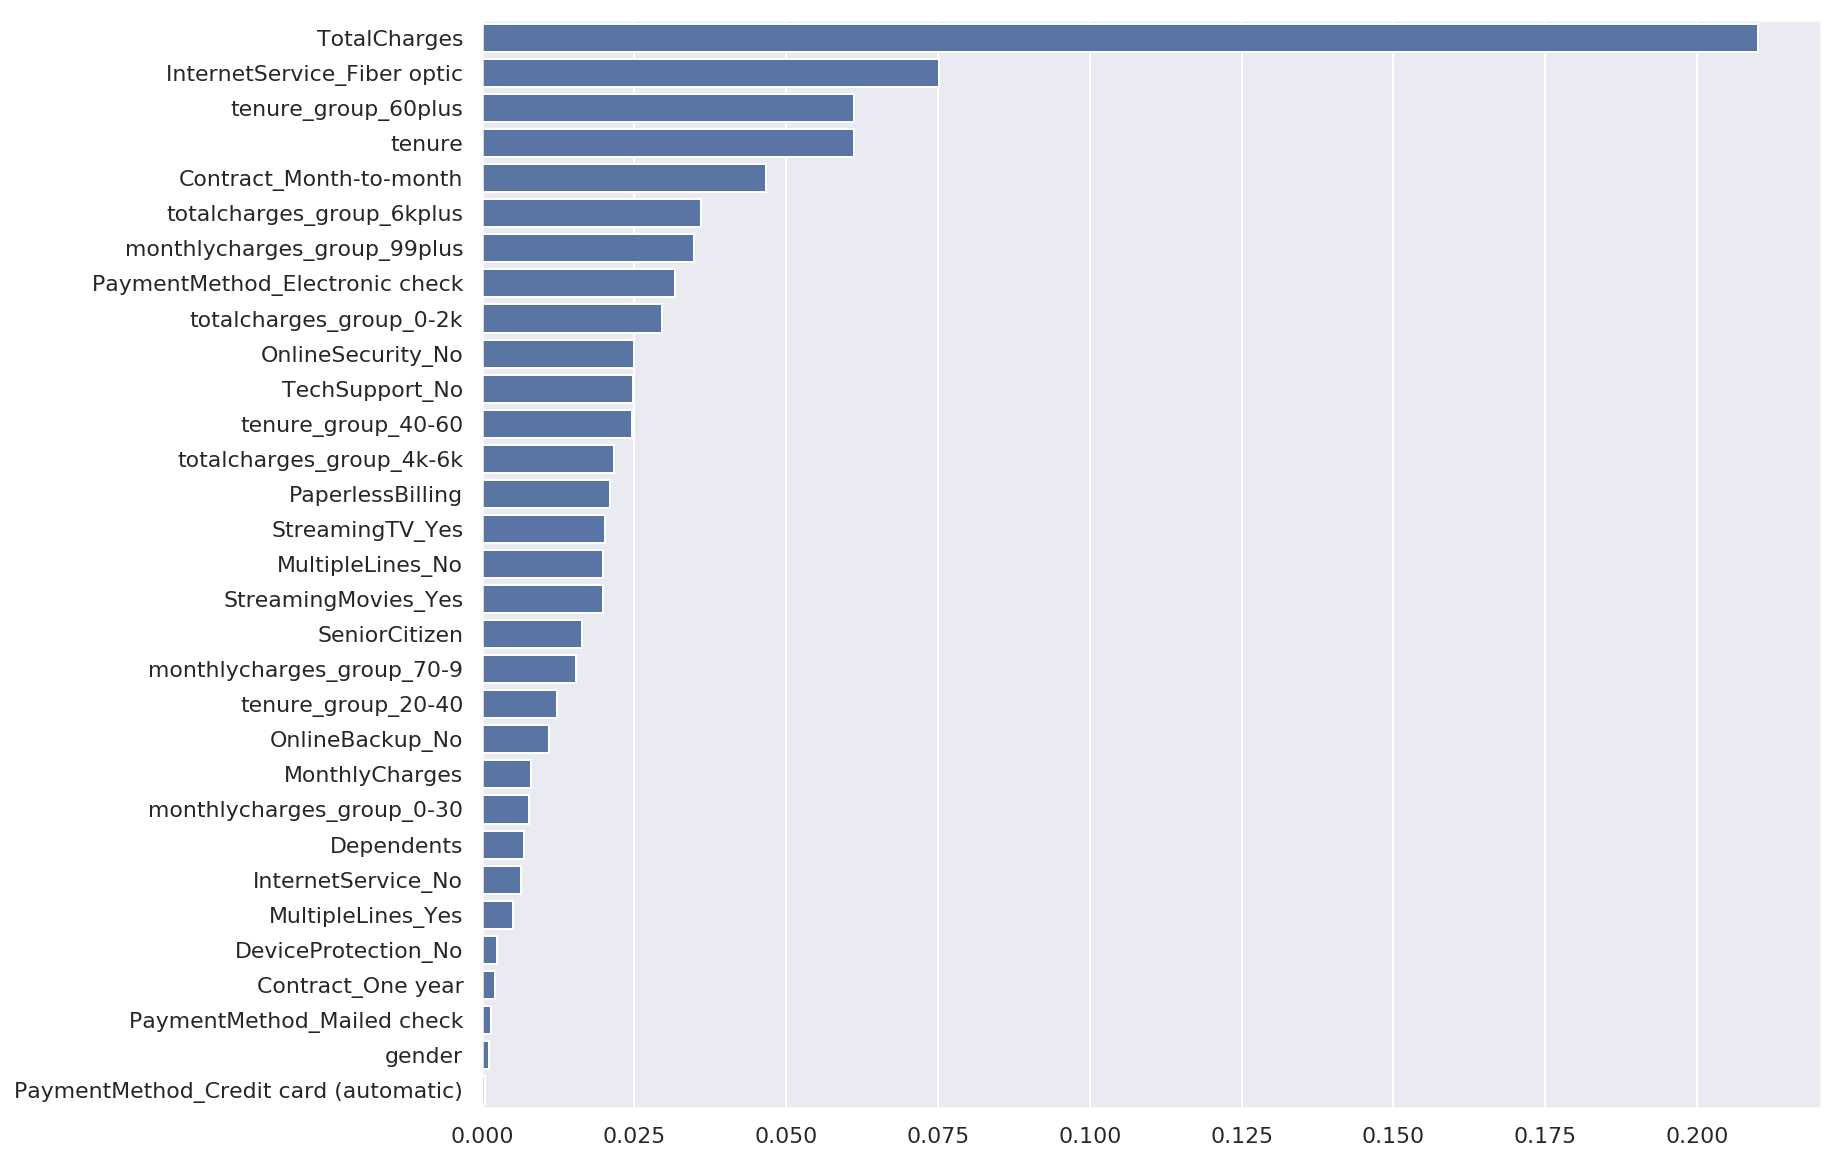

In [34]:
# see if you can extract the above results using Regular Expression

plot_feature = ['TotalCharges', 'InternetService_Fiber optic', 'tenure_group_60plus', 'tenure', 'Contract_Month-to-month', 
                'totalcharges_group_6kplus', 'monthlycharges_group_99plus', 'PaymentMethod_Electronic check', 
                'totalcharges_group_0-2k', 'OnlineSecurity_No', 'TechSupport_No', 'tenure_group_40-60', 
                'totalcharges_group_4k-6k', 'PaperlessBilling', 'StreamingTV_Yes', 'MultipleLines_No', 'StreamingMovies_Yes', 
                'SeniorCitizen', 'monthlycharges_group_70-9', 'tenure_group_20-40', 'OnlineBackup_No', 'MonthlyCharges', 
                'monthlycharges_group_0-30', 'Dependents', 'InternetService_No', 'MultipleLines_Yes', 'DeviceProtection_No', 
                'Contract_One year', 'PaymentMethod_Mailed check', 'gender', 'PaymentMethod_Credit card (automatic)']

lasso_coeff = [0.209954752, 0.075144498, 0.061184581, 0.061182631, 0.046630292, 0.036007041, 0.034846244, 0.031775227, 
               0.029645254, 0.024949481, 0.024875392, 0.024679595, 0.021639644, 0.020966614, 0.020143496, 0.019954793, 
               0.019936301, 0.016463024, 0.015436581, 0.012221305, 0.011015587, 0.008054301, 0.007701626, 0.006895811, 
               0.00642757, 0.005009993, 0.002481356, 0.002102214, 0.001449537, 0.001066809, 0.000525379]

sns.barplot(y = plot_feature, x = lasso_coeff, color='b')

Text(0.5, 1.0, 'Top Features derived by Random Forest')

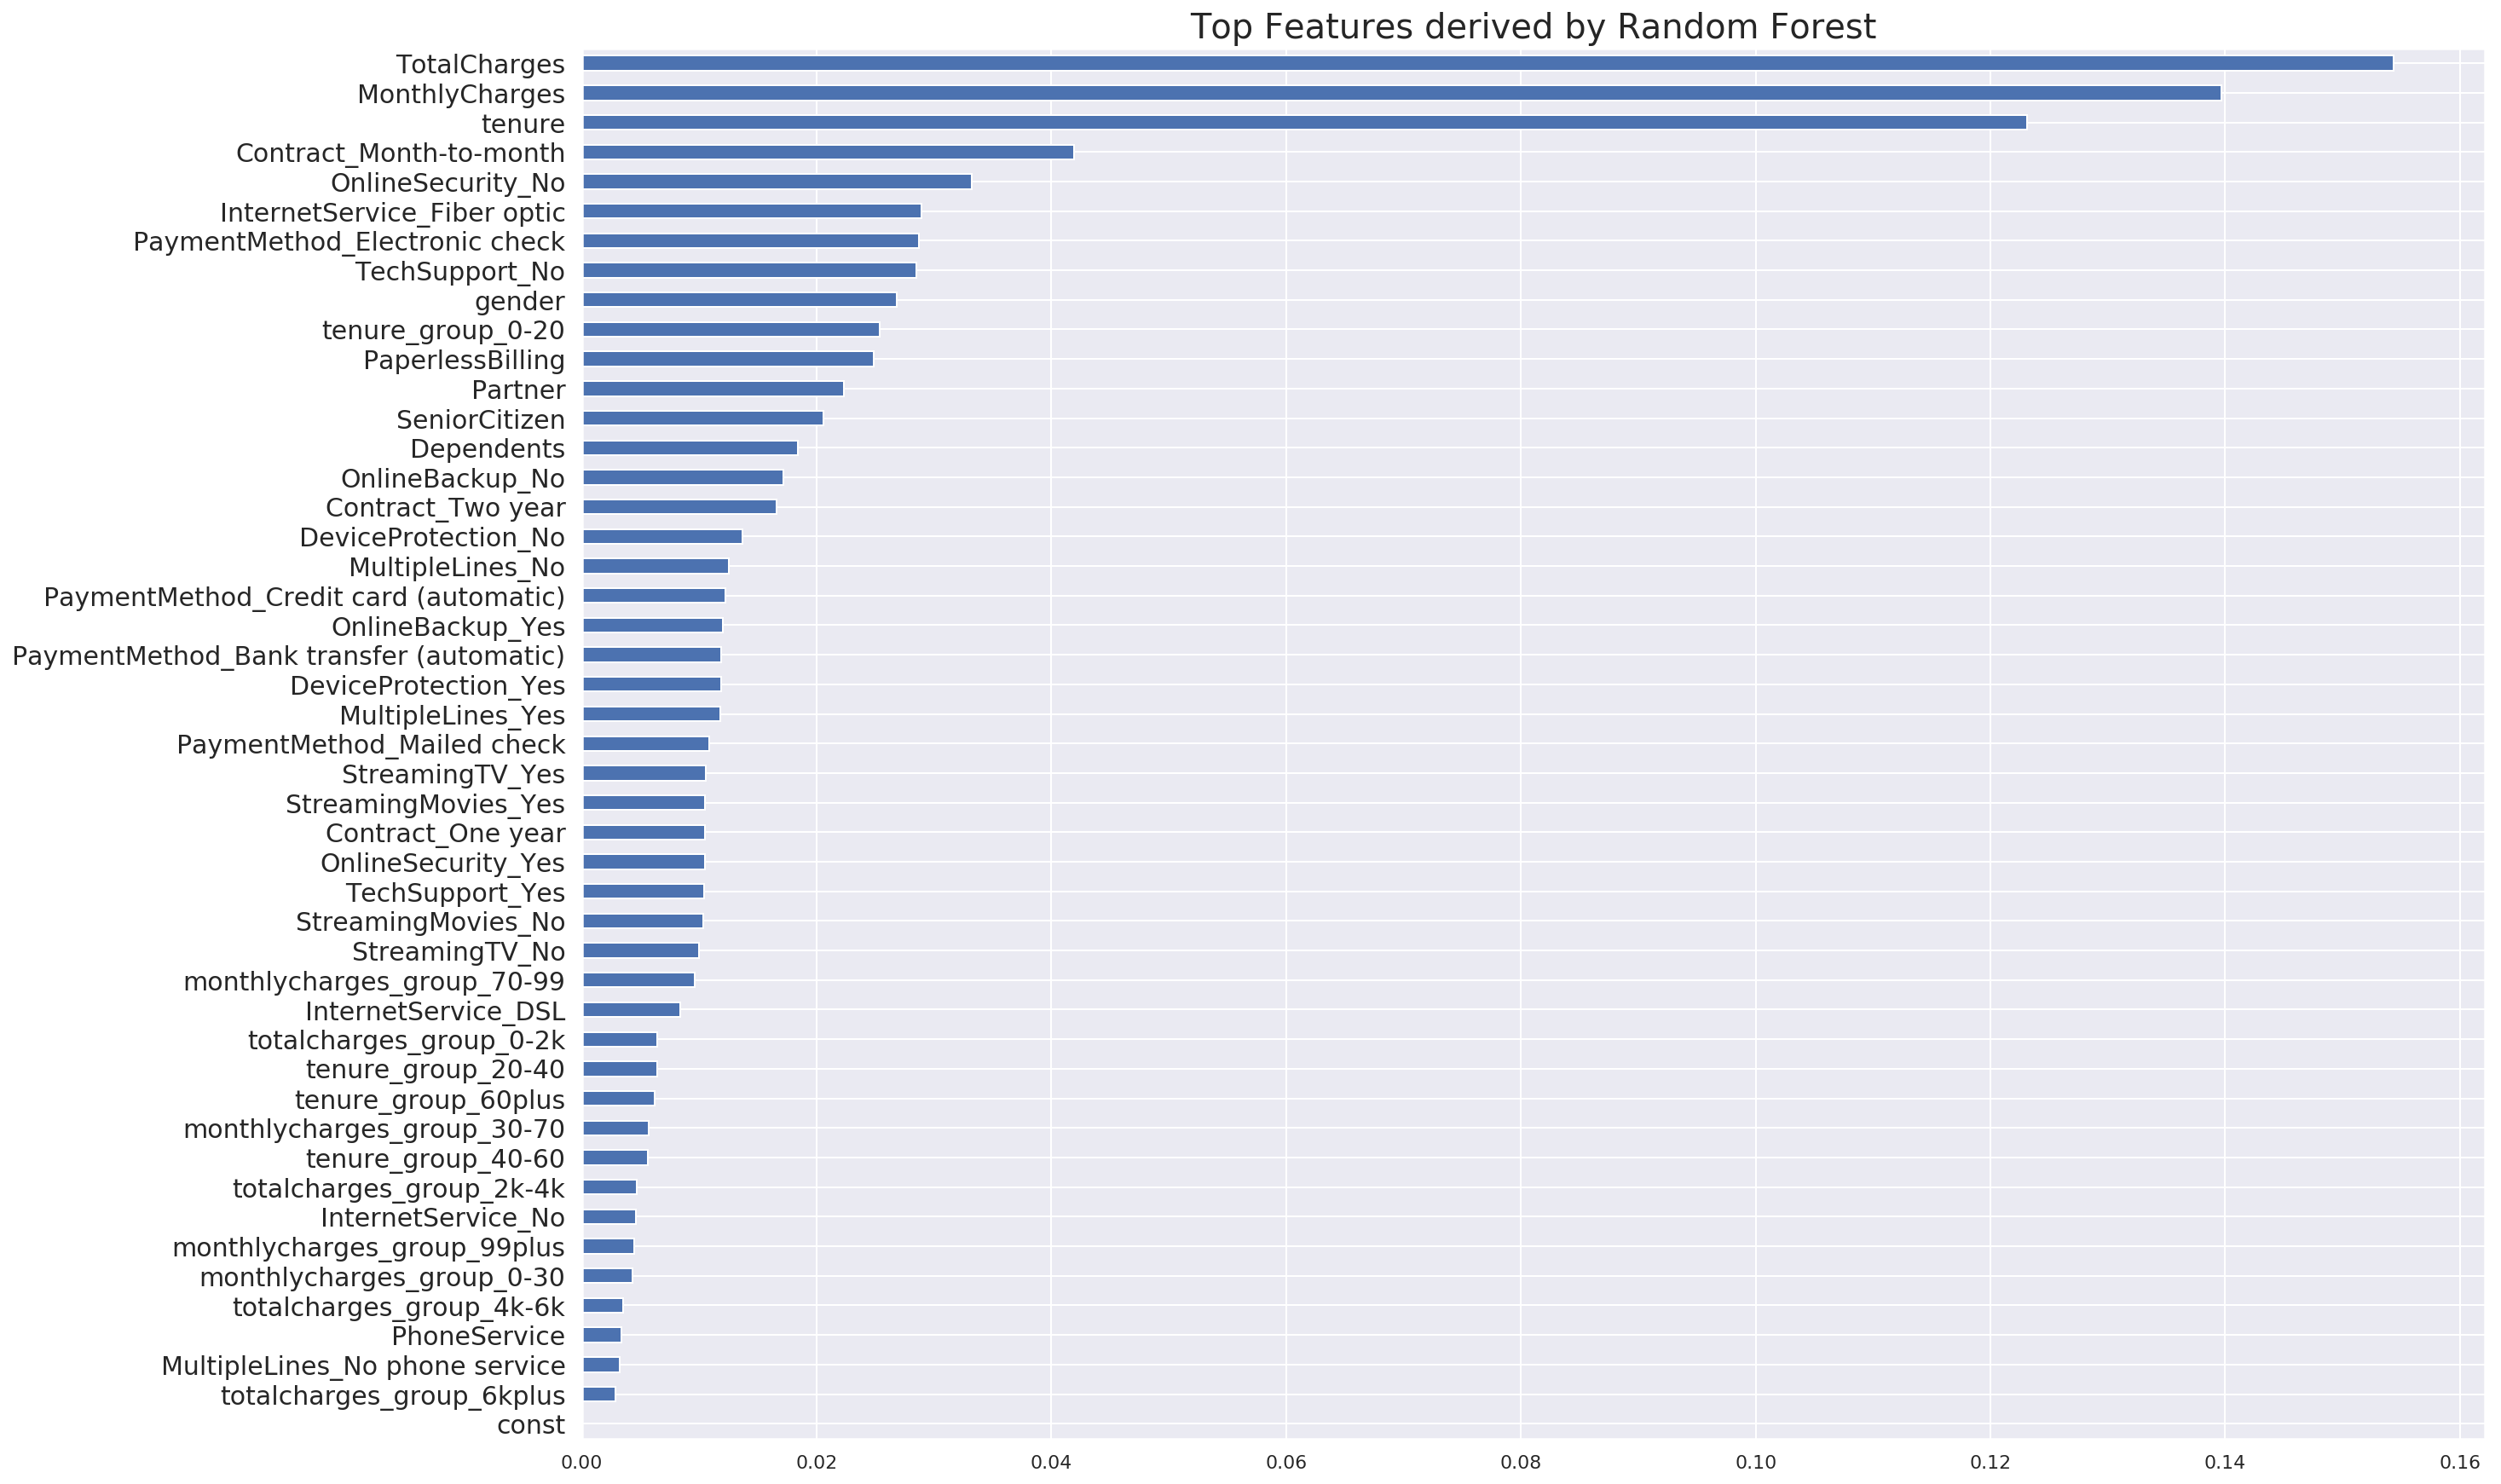

In [35]:
## To look for top features using Random Forest
# Create decision tree classifer object
rfc = RandomForestClassifier(random_state=0, n_estimators=100)

# Train model, note that NO scaling is required
model = rfc.fit(X, y)

# Plot the top features based on its importance
(pd.Series(model.feature_importances_, index=X.columns)
   .nlargest(47)   # can adjust based on how many top features you want
   .plot(kind='barh', figsize=[20,15])
    .invert_yaxis()) # Ensures that the feature with the most importance is on top, in descending order

plt.yticks(size=15)
plt.title('Top Features derived by Random Forest', size=20)

Finally, I evaluated the Logistic Regression model on test data. Features are sorted in descending order of importance from the list of 47 features. Depending on the number of features used in the model, the performance scores are different. Notice that there is a diminishing marginal improvement in the F1-Score.
In conclusion, I would propose to implement the Logistic Regression model with these top 18 features. And business can also focus on this list of features to understand whether a customer will likely to churn or not.

## Model Selection

In [36]:
df1 = pd.read_csv('df1.csv')
X, y = df1.drop('Churn',axis=1), df1[['Churn']]

I have tested 8 classification models, trained them, optimise them, and here are the results. Logistic Regression generally works well on binary classification and has performed better than the rest. **F1-Score** is a balance between Precision and Recall rates trade-off.

In [37]:
# # This section is used to select the top features (subset, instead of all features) to run on the model 
# X = df1[ ['tenure_group_0-20', 'tenure_group_60plus', 'monthlycharges_group_0-30', 'monthlycharges_group_70-99', 
#           'totalcharges_group_6kplus', 'totalcharges_group_0-2k', 'SeniorCitizen', 'InternetService_Fiber optic', 
#           'InternetService_No', 'OnlineSecurity_No', 'OnlineBackup_No', 'DeviceProtection_No', 'TechSupport_No', 
#           'PaymentMethod_Electronic check', 'PaymentMethod_Credit card (automatic)', 'PaperlessBilling', 
#           'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'StreamingTV_No', 'StreamingMovies_No', 
#           'TotalCharges', 'tenure'] ]
# y = df1[['Churn']]

In [38]:
# split data to 80:20 ratio for train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=71)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

def model_report(model_name, model):
    print('\nSearch for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data')
    model.fit(X_train, y_train)
    optimal_th = 0.5   # start with default threshold value
    
    for i in range(0,3):
        score_list = []
        print('\nLooping decimal place', i+1) 
        th_list = [np.linspace(optimal_th-0.4999, optimal_th+0.4999, 11), 
                  # eg [ 0.0001 , 0.1008, 0.2006, 0.3004, 0.4002, 0.5, 0.5998, 0.6996, 0.7994, 0.8992, 0.9999 ]
                 np.linspace(optimal_th-0.1, optimal_th+0.1, 21), 
                  # eg 0.3xx [ 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 ]
                 np.linspace(optimal_th-0.01, optimal_th+0.01, 21)]
                  # eg 0.30x [ 0.29 , 0.291, 0.292, 0.293, 0.294, 0.295, 0.296, 0.297, 0.298, 0.299, 0.3  , 0.301, 0.302, 0.303, 0.304, 0.305, 0.306, 0.307, 0.308, 0.309, 0.31 ]
        for th in th_list[i]:
            y_pred = (model.predict_proba(X_test)[:,1] >= th)
            f1scor = f1_score(y_test, y_pred)
            score_list.append(f1scor)
            print('{:.3f}->{:.4f}'.format(th, f1scor), end=',  ')   # display score in 4 decimal pl
        optimal_th = float(th_list[i][score_list.index(max(score_list))])

    print('optimal F1 score = {:.4f}'.format(max(score_list)))
    print('optimal threshold = {:.3f}'.format(optimal_th))

    print(model_name, 'accuracy score is')
    print('Training: {:.2f}%'.format(100*model.score(X_train, y_train)))  # score uses accuracy
    print('Test set: {:.2f}%'.format(100*model.score(X_test, y_test)))   # should use cross validation

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.25)
    print('\nAdjust threshold to 0.25:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = model.predict(X_test)
    print('\nDefault threshold of 0.50:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.75)
    print('\nAdjust threshold to 0.75:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= optimal_th)
    print('\nOptimal threshold {:.3f}'.format(optimal_th))
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))
    
    global model_f1, model_auc, model_ll, model_roc_auc
    model_f1 = f1_score(y_test, y_pred)

    y_pred = model.predict_proba(X_test)
    model_ll = log_loss(y_test, y_pred)
    print(model_name, 'Log-loss: {:.4f}'.format(model_ll))
    y_pred = model.predict(X_test)
    model_roc_auc = roc_auc_score(y_test, y_pred)
    print(model_name, 'roc_auc_score: {:.4f}'.format(model_roc_auc)) 
    y_pred = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    model_auc = auc(fpr, tpr)
    print(model_name, 'AUC: {:.4f}'.format(model_auc))

    # plot the ROC curve
    plt.figure(figsize = [6,6])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % model_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    # plt.savefig('roc_auc_score')
    plt.show()
  
    return

# initialise lists to collect the results to plot later
model_list = []
f1_list = []
auc_list = []
ll_list = []
roc_auc_list = []
time_list = []

X_train (5625, 46)
y_train (5625, 1)
X_test (1407, 46)
y_test (1407, 1)



"""""" GaussianNB """"""

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.5794,  0.100->0.6181,  0.200->0.6213,  0.300->0.6228,  0.400->0.6251,  0.500->0.6269,  0.600->0.6249,  0.700->0.6264,  0.800->0.6274,  0.900->0.6274,  1.000->0.5710,  
Looping decimal place 2
0.800->0.6274,  0.810->0.6280,  0.820->0.6266,  0.830->0.6258,  0.840->0.6285,  0.850->0.6283,  0.860->0.6275,  0.870->0.6261,  0.880->0.6267,  0.890->0.6274,  0.900->0.6274,  0.910->0.6288,  0.920->0.6293,  0.930->0.6255,  0.940->0.6276,  0.950->0.6251,  0.960->0.6278,  0.970->0.6304,  0.980->0.6323,  0.990->0.6269,  1.000->0.5714,  
Looping decimal place 3
0.970->0.6304,  0.971->0.6318,  0.972->0.6318,  0.973->0.6318,  0.974->0.6310,  0.975->0.6310,  0.976->0.6331,  0.977->0.6331,  0.978->0.6331,  0.979->0.6316,  0.980->0.6323,  0.981->0.6330,  0.982->0.6330,  0.983->0.6337,  0.984->0.6322,  0.985->0.6282,  0.986->0.6290,  0.987->0.6295,  0.988->0.

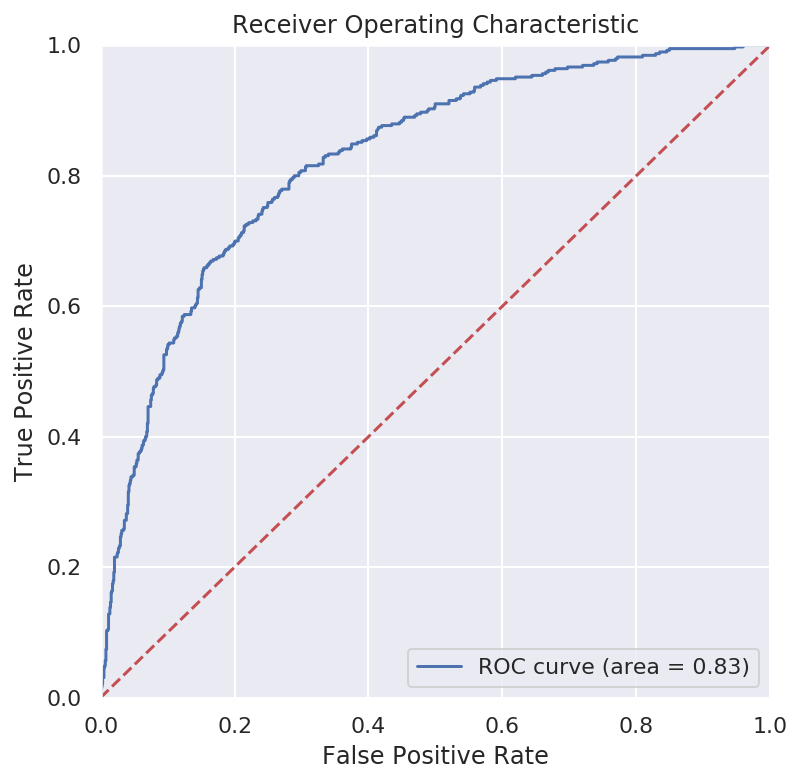


"""""" BernoulliNB """"""

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.5449,  0.100->0.6212,  0.200->0.6242,  0.300->0.6254,  0.400->0.6283,  0.500->0.6324,  0.600->0.6318,  0.700->0.6381,  0.800->0.6410,  0.900->0.6330,  1.000->0.2462,  
Looping decimal place 2
0.700->0.6381,  0.710->0.6387,  0.720->0.6402,  0.730->0.6394,  0.740->0.6408,  0.750->0.6400,  0.760->0.6414,  0.770->0.6436,  0.780->0.6396,  0.790->0.6404,  0.800->0.6410,  0.810->0.6417,  0.820->0.6408,  0.830->0.6423,  0.840->0.6406,  0.850->0.6396,  0.860->0.6369,  0.870->0.6353,  0.880->0.6382,  0.890->0.6373,  0.900->0.6330,  
Looping decimal place 3
0.760->0.6414,  0.761->0.6421,  0.762->0.6429,  0.763->0.6429,  0.764->0.6436,  0.765->0.6436,  0.766->0.6436,  0.767->0.6436,  0.768->0.6436,  0.769->0.6436,  0.770->0.6436,  0.771->0.6436,  0.772->0.6412,  0.773->0.6412,  0.774->0.6412,  0.775->0.6396,  0.776->0.6396,  0.777->0.6396,  0.778->0

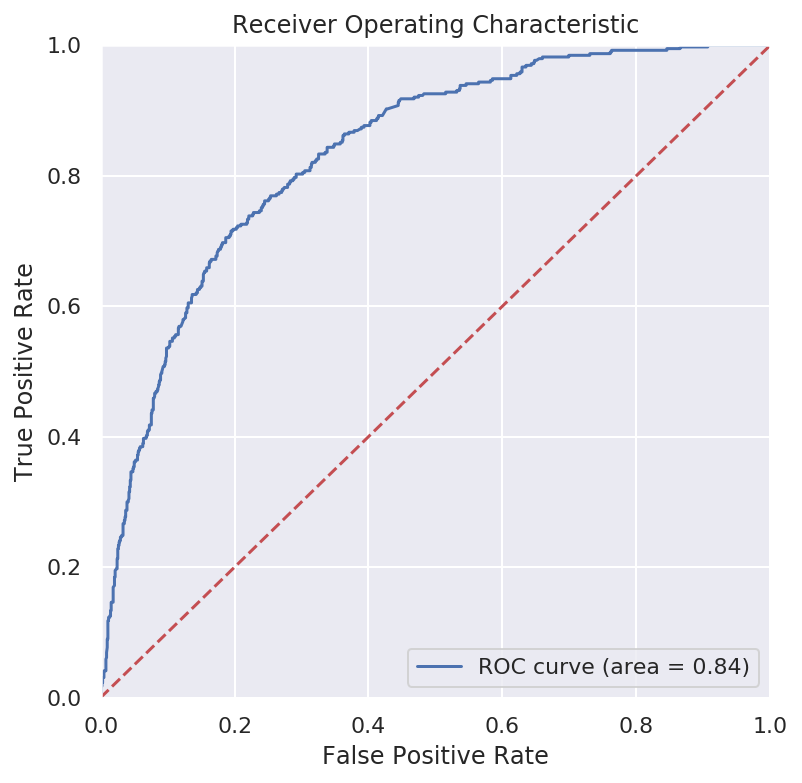

In [39]:
print('\n"""""" GaussianNB """"""')
time1 = time.time()
gnb = GaussianNB()
model_report('GaussianNB', gnb)

model_list.append('GaussianNB')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

print('\n"""""" BernoulliNB """"""')
time1 = time.time()
bnb = BernoulliNB()
model_report('BernoulliNB', bnb)

model_list.append('BernoulliNB')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

### this model does not work
# print('\n"""""" MultinomialNB """"""')
# mnb = MultinomialNB()
# model_report('MultinomialNB', mnb)

In [40]:
# Optimal threshold 0.983
# Precision: 0.5640,   Recall: 0.7231,   F1 Score: 0.6337
# GaussianNB confusion matrix: 
#  [[799 218]
#  [108 282]]
# GaussianNB Log-loss: 2.3984
# GaussianNB roc_auc_score: 0.7554
# GaussianNB AUC: 0.8265
    
# Optimal threshold 0.764
# Precision: 0.5849,   Recall: 0.7154,   F1 Score: 0.6436
# BernoulliNB confusion matrix: 
#  [[819 198]
#  [111 279]]
# BernoulliNB Log-loss: 1.1281
# BernoulliNB roc_auc_score: 0.7563
# BernoulliNB AUC: 0.8355


"""""" LogisticRegression """"""

Search for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold(5) Cross Validation on train data
0.3675, 0.3889, 0.4071, 0.4196, 0.4302, 0.4450, 0.4523, 0.4578, 0.4699, 0.4785, 0.4851, 0.4896, 0.4930, 0.4971, 0.5041, 0.5122, 0.5151, 0.5227, 0.5269, 0.5348, 0.5369, 0.5369, 0.5393, 0.5408, 0.5445, 0.5447, 0.5516, 0.5510, 0.5563, 0.5633, 0.5626, 0.5638, 0.5664, 0.5684, 0.5696, 0.5699, 0.5720, 0.5725, 0.5739, 0.5742, 0.5745, 0.5749, 0.5774, 0.5781, 0.5785, 0.5780, 0.5782, 0.5790, 0.5780, 0.5788, 0.5812, 0.5811, 0.5789, 0.5783, 0.5779, 0.5780, 0.5791, 0.5794, 0.5801, 0.5802, 0.5811, 0.5819, 0.5810, 0.5807, 0.5822, 0.5823, 0.5821, 0.5825, 0.5825, 0.5830, 0.5829, 0.5840, 0.5841, 0.5847, 0.5852, 0.5860, 0.5861, 0.5852, 0.5872, 0.5863, 0.5855, 0.5852, 0.5867, 0.5872, 0.5869, 0.5871, 0.5871, 0.5877, 0.5866, 0.5860, 0.5855, 0.5859, 0.5854, 0.5852, 0.5854, 0.5840, 0.5838, 0.5839, 0.5840, 0.5840, 0.5834, 0.5840, 0.5832, 0.5838, 

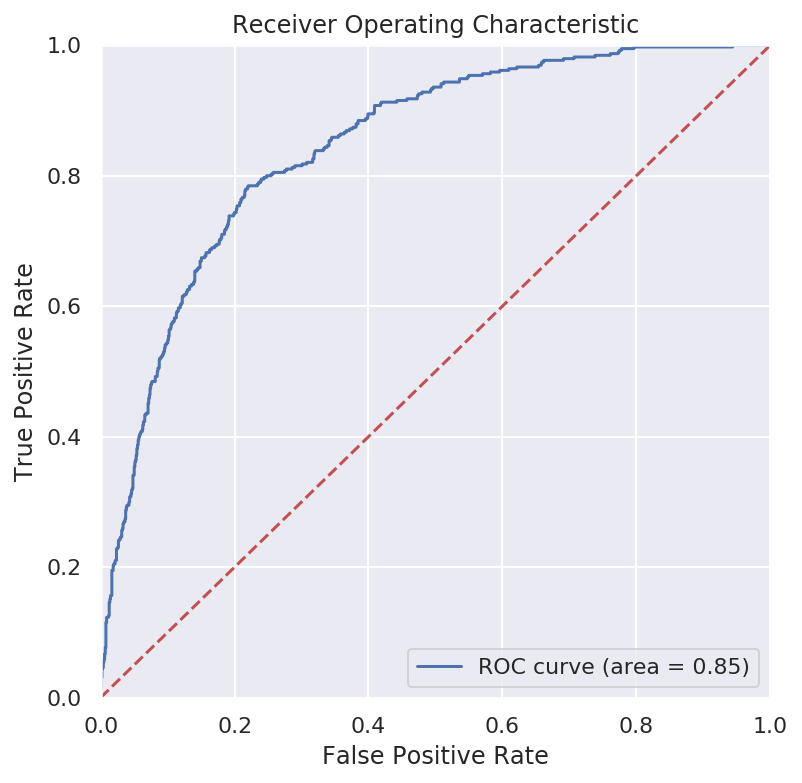

In [41]:
print('\n"""""" LogisticRegression """"""')
print('\nSearch for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=21, shuffle=True)  #produce the k folds
score_list = []
c_list = 10**np.linspace(-3,3,200)
for c in c_list:
    logit = LogisticRegression(C = c)
    cvs = (cross_val_score(logit, X_train, y_train, cv=kf, scoring='f1')).mean()
    score_list.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")   # 4 decimal pl
print('optimal cv F1 score = {:.4f}'.format(max(score_list)))
optimal_c = float(c_list[score_list.index(max(score_list))])
print('optimal value of C = {:.3f}'.format(optimal_c))

time1 = time.time()
logit = LogisticRegression(C = optimal_c)
model_report('LogisticRegression', logit)

model_list.append('LogisticRegression')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

In [42]:
# logit = LogisticRegression(C = 0.1825)
# Adjust threshold to 0.3181:
# Precision: 0.5659,   Recall: 0.7787,   F1 Score: 0.6554
# Logistic confusion matrix: 
#  [[806 224]
#  [ 83 292]]
# Log-loss on logit: 0.4073


"""""" KNN """""" (quite slow)

Search for optimal hyperparameter K in KNN, vary K from 1 to 20, using KFold(5) Cross Validation on train data
0.4677, 0.3922, 0.5218, 0.4669, 0.5325, 0.4942, 0.5513, 0.5170, 0.5648, 0.5280, 0.5565, 0.5391, 0.5627, 0.5446, 0.5685, 0.5487, 0.5757, 0.5594, 0.5760, 0.5590, optimal cv F1 score = 0.5760
optimal value of K = 19

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.5030,  0.100->0.5451,  0.200->0.5937,  0.300->0.6293,  0.400->0.6266,  0.500->0.5947,  0.600->0.4934,  0.700->0.3386,  0.800->0.1485,  0.900->0.0353,  1.000->0.0153,  
Looping decimal place 2
0.200->0.5937,  0.210->0.5937,  0.220->0.6175,  0.230->0.6175,  0.240->0.6175,  0.250->0.6175,  0.260->0.6175,  0.270->0.6293,  0.280->0.6293,  0.290->0.6293,  0.300->0.6293,  0.310->0.6293,  0.320->0.6167,  0.330->0.6167,  0.340->0.6167,  0.350->0.6167,  0.360->0.6167,  0.370->0.6266,  0.380->0.6266,  0.390->0.6266,  0.400->

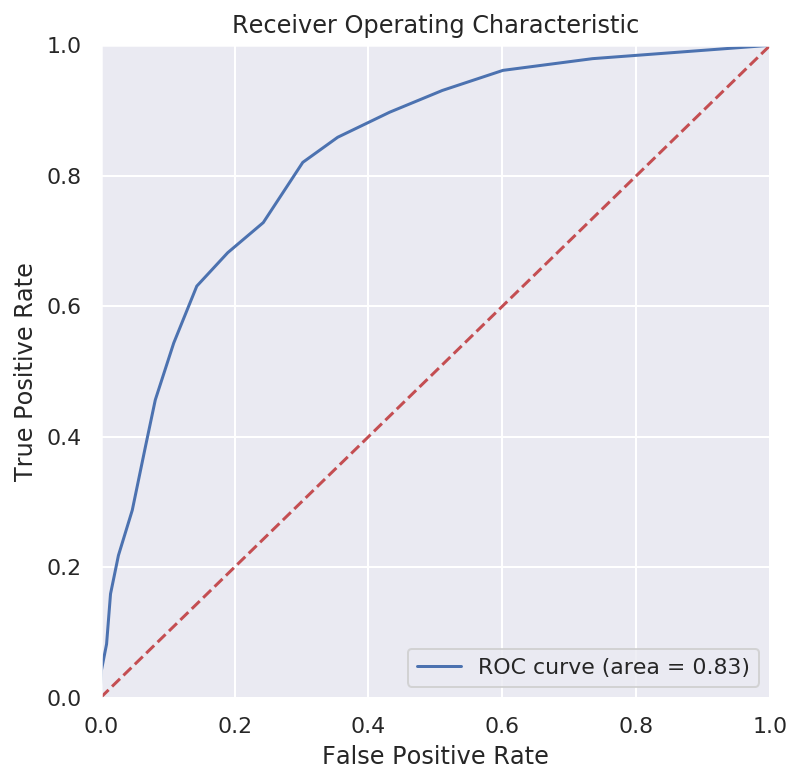


Compare with KNN classification_report (same as default threshold 0.50)
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1017
           1       0.66      0.54      0.59       390

    accuracy                           0.79      1407
   macro avg       0.75      0.72      0.73      1407
weighted avg       0.79      0.79      0.79      1407



In [43]:
print('\n"""""" KNN """""" (quite slow)')
print('\nSearch for optimal hyperparameter K in KNN, vary K from 1 to 20, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=21, shuffle=True)  #produce the k folds
k_scores = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors = k)
    cvs = cross_val_score(knn, X_train, y_train, cv=kf, scoring='f1').mean()
    k_scores.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")
print('optimal cv F1 score = {:.4f}'.format(max(k_scores)))   # 4 decimal pl
optimal_k = k_scores.index(max(k_scores))+1   # index 0 is for k=1
print('optimal value of K =', optimal_k)

time1 = time.time()
knn = KNeighborsClassifier(n_neighbors = optimal_k)
model_report('KNN', knn)

print('\nCompare with KNN classification_report (same as default threshold 0.50)')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

model_list.append('KNN')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

In [44]:
# Optimal threshold 0.264
# Precision: 0.5104,   Recall: 0.8205,   F1 Score: 0.6293
# KNN confusion matrix: 
#  [[710 307]
#  [ 70 320]]
# KNN Log-loss: 0.6104
# KNN roc_auc_score: 0.7172
# KNN AUC: 0.8309


"""""" DecisionTreeClassifier """"""

Search for optimal max_depth in DecisionTree, vary 2 to 10, using KFold(5) Cross Validation on train data
0.5787, 0.5062, 0.5624, 0.5607, 0.5642, 0.5642, 0.5298, 0.5321, 0.5342, optimal F1 score = 0.5787
optimal max_depth = 2

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.4341,  0.100->0.5480,  0.200->0.5811,  0.300->0.5911,  0.400->0.5911,  0.500->0.5911,  0.600->0.0000,  0.700->0.0000,  0.800->0.0000,  0.900->0.0000,  1.000->0.0000,  
Looping decimal place 2
0.200->0.5811,  0.210->0.5811,  0.220->0.5811,  0.230->0.5811,  0.240->0.5811,  0.250->0.5811,  0.260->0.5811,  0.270->0.5811,  0.280->0.5811,  0.290->0.5911,  0.300->0.5911,  0.310->0.5911,  0.320->0.5911,  0.330->0.5911,  0.340->0.5911,  0.350->0.5911,  0.360->0.5911,  0.370->0.5911,  0.380->0.5911,  0.390->0.5911,  0.400->0.5911,  
Looping decimal place 3
0.280->0.5811,  0.281->0.5811,  0.282->0.5811,  0.283->0.5

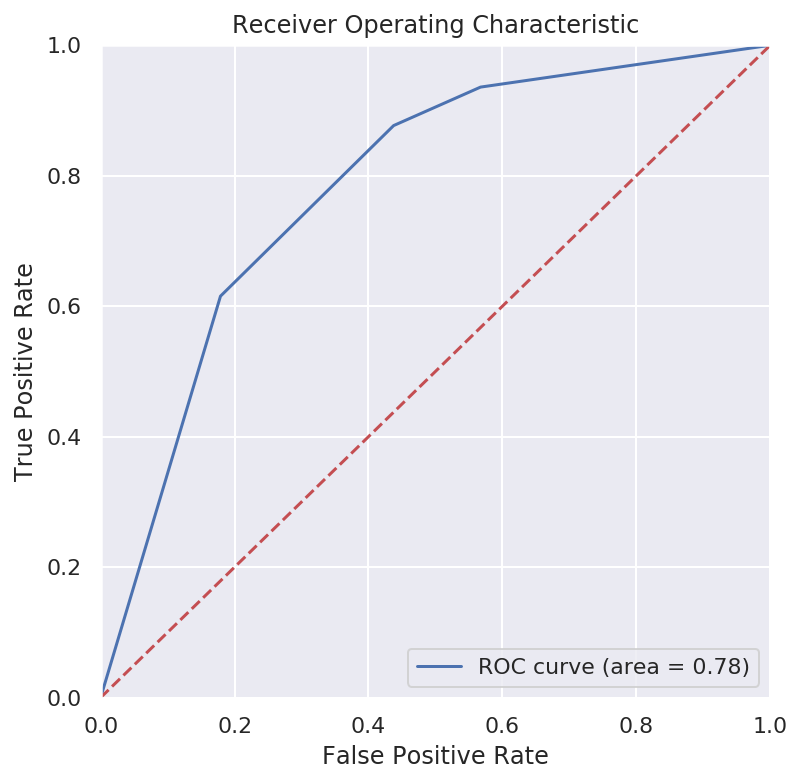

In [45]:
print('\n"""""" DecisionTreeClassifier """"""')

print('\nSearch for optimal max_depth in DecisionTree, vary 2 to 10, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=21, shuffle=True)  #produce the k folds
d_scores = []
for d in range(2, 11):
    decisiontree = DecisionTreeClassifier(max_depth=d)
    cvs = cross_val_score(decisiontree, X_train, y_train, cv=kf, scoring='f1').mean()
    d_scores.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")
print('optimal F1 score = {:.4f}'.format(max(d_scores)))   # 4 decimal pl
optimal_d = d_scores.index(max(d_scores))+2   # index 0 is for d=2
print('optimal max_depth =', optimal_d)

time1 = time.time()
decisiontree = DecisionTreeClassifier(max_depth=optimal_d)
model_report('DecisionTreeClassifier', decisiontree)

model_list.append('DecisionTreeClassifier')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

In [46]:
# Optimal threshold 0.2866
# Precision: 0.5687,   Recall: 0.6154,   F1 Score: 0.5911
# DecisionTreeClassifier confusion matrix: 
#  [[835 182]
#  [150 240]]


"""""" RandomForestClassifier """""" (quite slow)

Search for optimal n_estimators in RandomForest, vary 100 to 500, using KFold(5) Cross Validation on train data
100->0.5498, 150->0.5354, 200->0.5471, 250->0.5511, 300->0.5499, 350->0.5483, 400->0.5447, 450->0.5480, 500->0.5467, optimal F1 score = 0.5511
optimal n_estimators = 250

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.4661,  0.100->0.5571,  0.200->0.6139,  0.300->0.6287,  0.400->0.6199,  0.500->0.5651,  0.600->0.4890,  0.700->0.3647,  0.800->0.2314,  0.900->0.1280,  1.000->0.0102,  
Looping decimal place 2
0.200->0.6139,  0.210->0.6166,  0.220->0.6164,  0.230->0.6208,  0.240->0.6239,  0.250->0.6263,  0.260->0.6296,  0.270->0.6338,  0.280->0.6317,  0.290->0.6335,  0.300->0.6287,  0.310->0.6265,  0.320->0.6304,  0.330->0.6293,  0.340->0.6240,  0.350->0.6228,  0.360->0.6217,  0.370->0.6184,  0.380->0.6244,  0.390->0.6258,  0.400->0.6199,  
Looping decim

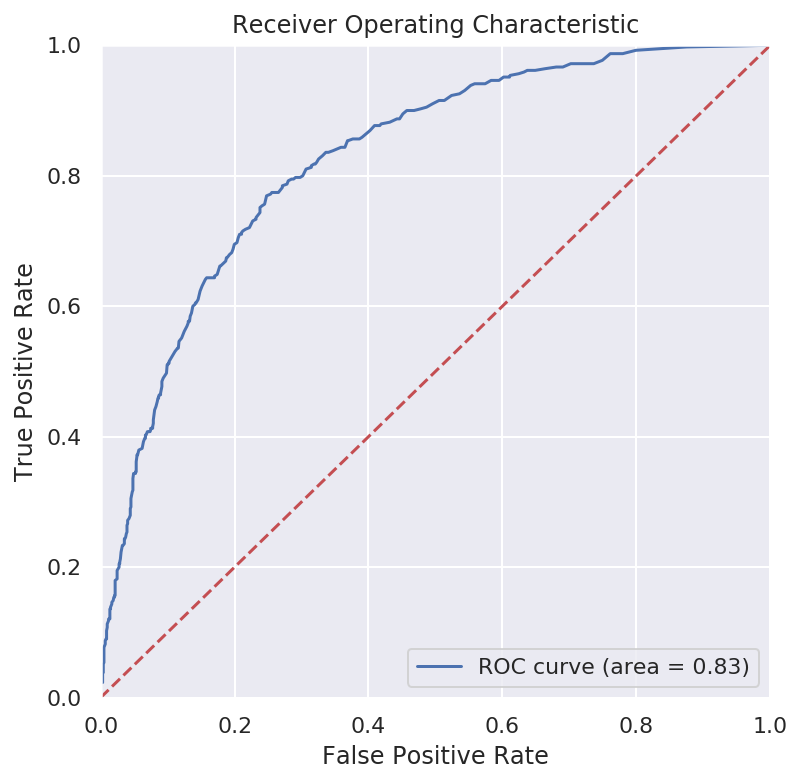

In [47]:
print('\n"""""" RandomForestClassifier """""" (quite slow)')

print('\nSearch for optimal n_estimators in RandomForest, vary 100 to 500, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=21, shuffle=True)  #produce the k folds
score_list = []
n_list = []
for n in [100, 150, 200, 250, 300, 350, 400, 450, 500]:
    randomforest = RandomForestClassifier(n_estimators=n)
    cvs = (cross_val_score(randomforest, X_train, y_train, cv=kf, scoring='f1')).mean()
    score_list.append(cvs)
    n_list.append(n)
    print('{:.0f}->{:.4f}'.format(n, cvs), end=", ")   # display score in 4 decimal place
print('optimal F1 score = {:.4f}'.format(max(score_list)))
optimal_n = int(n_list[score_list.index(max(score_list))])
print('optimal n_estimators = {:.0f}'.format(optimal_n))

time1 = time.time()
randomforest = RandomForestClassifier(n_estimators=optimal_n)
model_report('RandomForestClassifier', randomforest)

model_list.append('RandomForestClassifier')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

In [48]:
# Optimal threshold 0.340
# Precision: 0.5830,   Recall: 0.7026,   F1 Score: 0.6372
# RandomForestClassifier confusion matrix: 
#  [[821 196]
#  [116 274]]
# RandomForestClassifier Log-loss: 0.4724
# RandomForestClassifier roc_auc_score: 0.6946
# RandomForestClassifier AUC: 0.8272


"""""" LinearSVC """"""
LinearSVC accuracy score is
Training: 80.59%
Test set: 79.74%
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1017
           1       0.69      0.48      0.57       390

    accuracy                           0.80      1407
   macro avg       0.76      0.70      0.72      1407
weighted avg       0.79      0.80      0.79      1407

LinearSVC confusion matrix: 
 [[933  84]
 [201 189]]
LinearSVC Log-loss: 6.9962
LinearSVC roc_auc_score: 0.7010
LinearSVC AUC: 0.7010


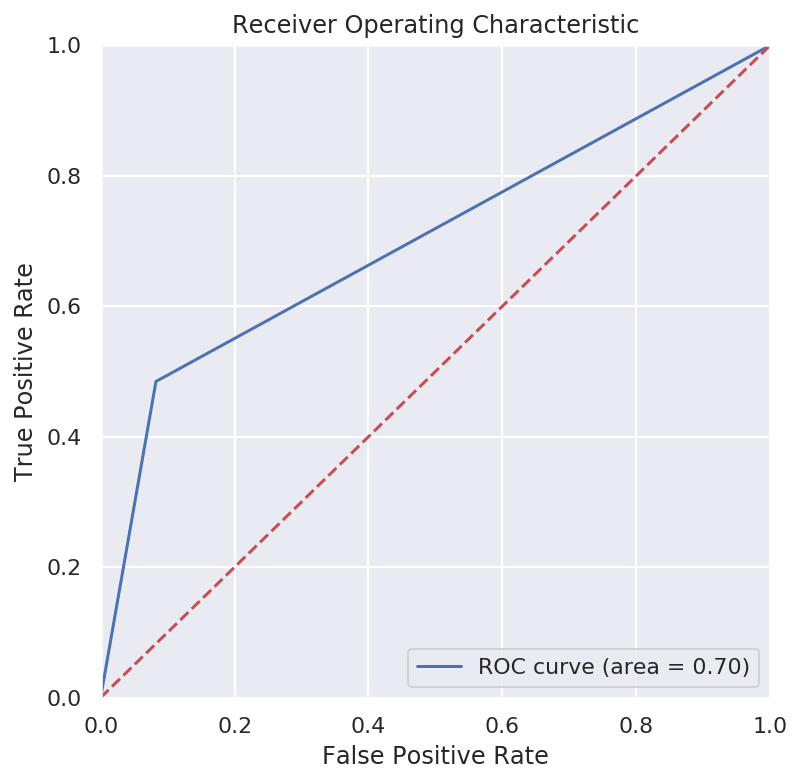

In [49]:
print('\n"""""" LinearSVC """"""')
time1 = time.time()
linearsvc = LinearSVC()
# model_report('LinearSVC', linearsvc)   # model has no attribute 'predict_proba'
linearsvc.fit(X_train, y_train)
print('LinearSVC accuracy score is')
print('Training: {:.2f}%'.format(100*linearsvc.score(X_train, y_train)))  # score uses accuracy
print('Test set: {:.2f}%'.format(100*linearsvc.score(X_test, y_test)))   # should use cross validation

y_pred = linearsvc.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print('LinearSVC confusion matrix: \n', confusion_matrix(y_test, y_pred))

model_f1 = f1_score(y_test, y_pred)

model_ll = log_loss(y_test, y_pred)
print('LinearSVC Log-loss: {:.4f}'.format(model_ll))
model_roc_auc = roc_auc_score(y_test, y_pred)
print('LinearSVC roc_auc_score: {:.4f}'.format(model_roc_auc)) 
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
model_auc = auc(fpr, tpr)
print('LinearSVC AUC: {:.4f}'.format(model_auc))

# plot the ROC curve
plt.figure(figsize = [6,6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % model_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
# plt.savefig('roc_auc_score')
plt.show()

model_list.append('LinearSVC')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

In [50]:
# LinearSVC confusion matrix: 
#  [[933  84]
#  [201 189]]
# LinearSVC Log-loss: 6.9962
# LinearSVC roc_auc_score: 0.7010
# LinearSVC AUC: 0.7010


"""""" SVC """""" (extremely slow)

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.4341,  0.100->0.4362,  0.200->0.6347,  0.300->0.6156,  0.400->0.5766,  0.500->0.5387,  0.600->0.4783,  0.700->0.3601,  0.800->0.1941,  0.900->0.0203,  1.000->0.0000,  
Looping decimal place 2
0.100->0.4362,  0.110->0.4401,  0.120->0.4464,  0.130->0.4645,  0.140->0.5131,  0.150->0.6068,  0.160->0.6296,  0.170->0.6447,  0.180->0.6462,  0.190->0.6480,  0.200->0.6347,  0.210->0.6382,  0.220->0.6360,  0.230->0.6307,  0.240->0.6253,  0.250->0.6273,  0.260->0.6277,  0.270->0.6226,  0.280->0.6137,  0.290->0.6162,  0.300->0.6156,  
Looping decimal place 3
0.180->0.6462,  0.181->0.6462,  0.182->0.6461,  0.183->0.6498,  0.184->0.6467,  0.185->0.6467,  0.186->0.6466,  0.187->0.6466,  0.188->0.6449,  0.189->0.6464,  0.190->0.6480,  0.191->0.6480,  0.192->0.6448,  0.193->0.6424,  0.194->0.6415,  0.195->0.6430,  0.196->0.6438,  0.197->0.6422, 

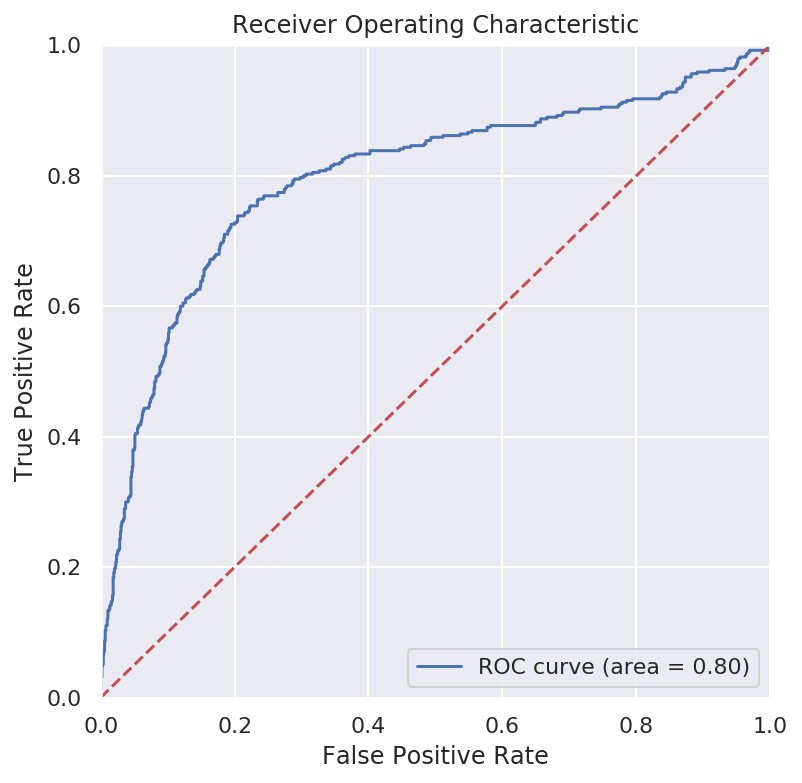

In [51]:
print('\n"""""" SVC """""" (extremely slow)')
time1 = time.time()
svc = SVC(gamma='scale', probability=True)
model_report('SVC', svc)

model_list.append('SVC')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
# time_list.append(time.time() - time1)   # use this line for actual time spent, or
time_list.append(0)                       # use this line to be able to see time spent for other models

In [52]:
# Optimal threshold 0.184
# Precision: 0.5884,   Recall: 0.7256,   F1 Score: 0.6498
# SVC confusion matrix: 
#  [[819 198]
#  [107 283]]
# SVC Log-loss: 0.4682
# SVC roc_auc_score: 0.6921
# SVC AUC: 0.7970

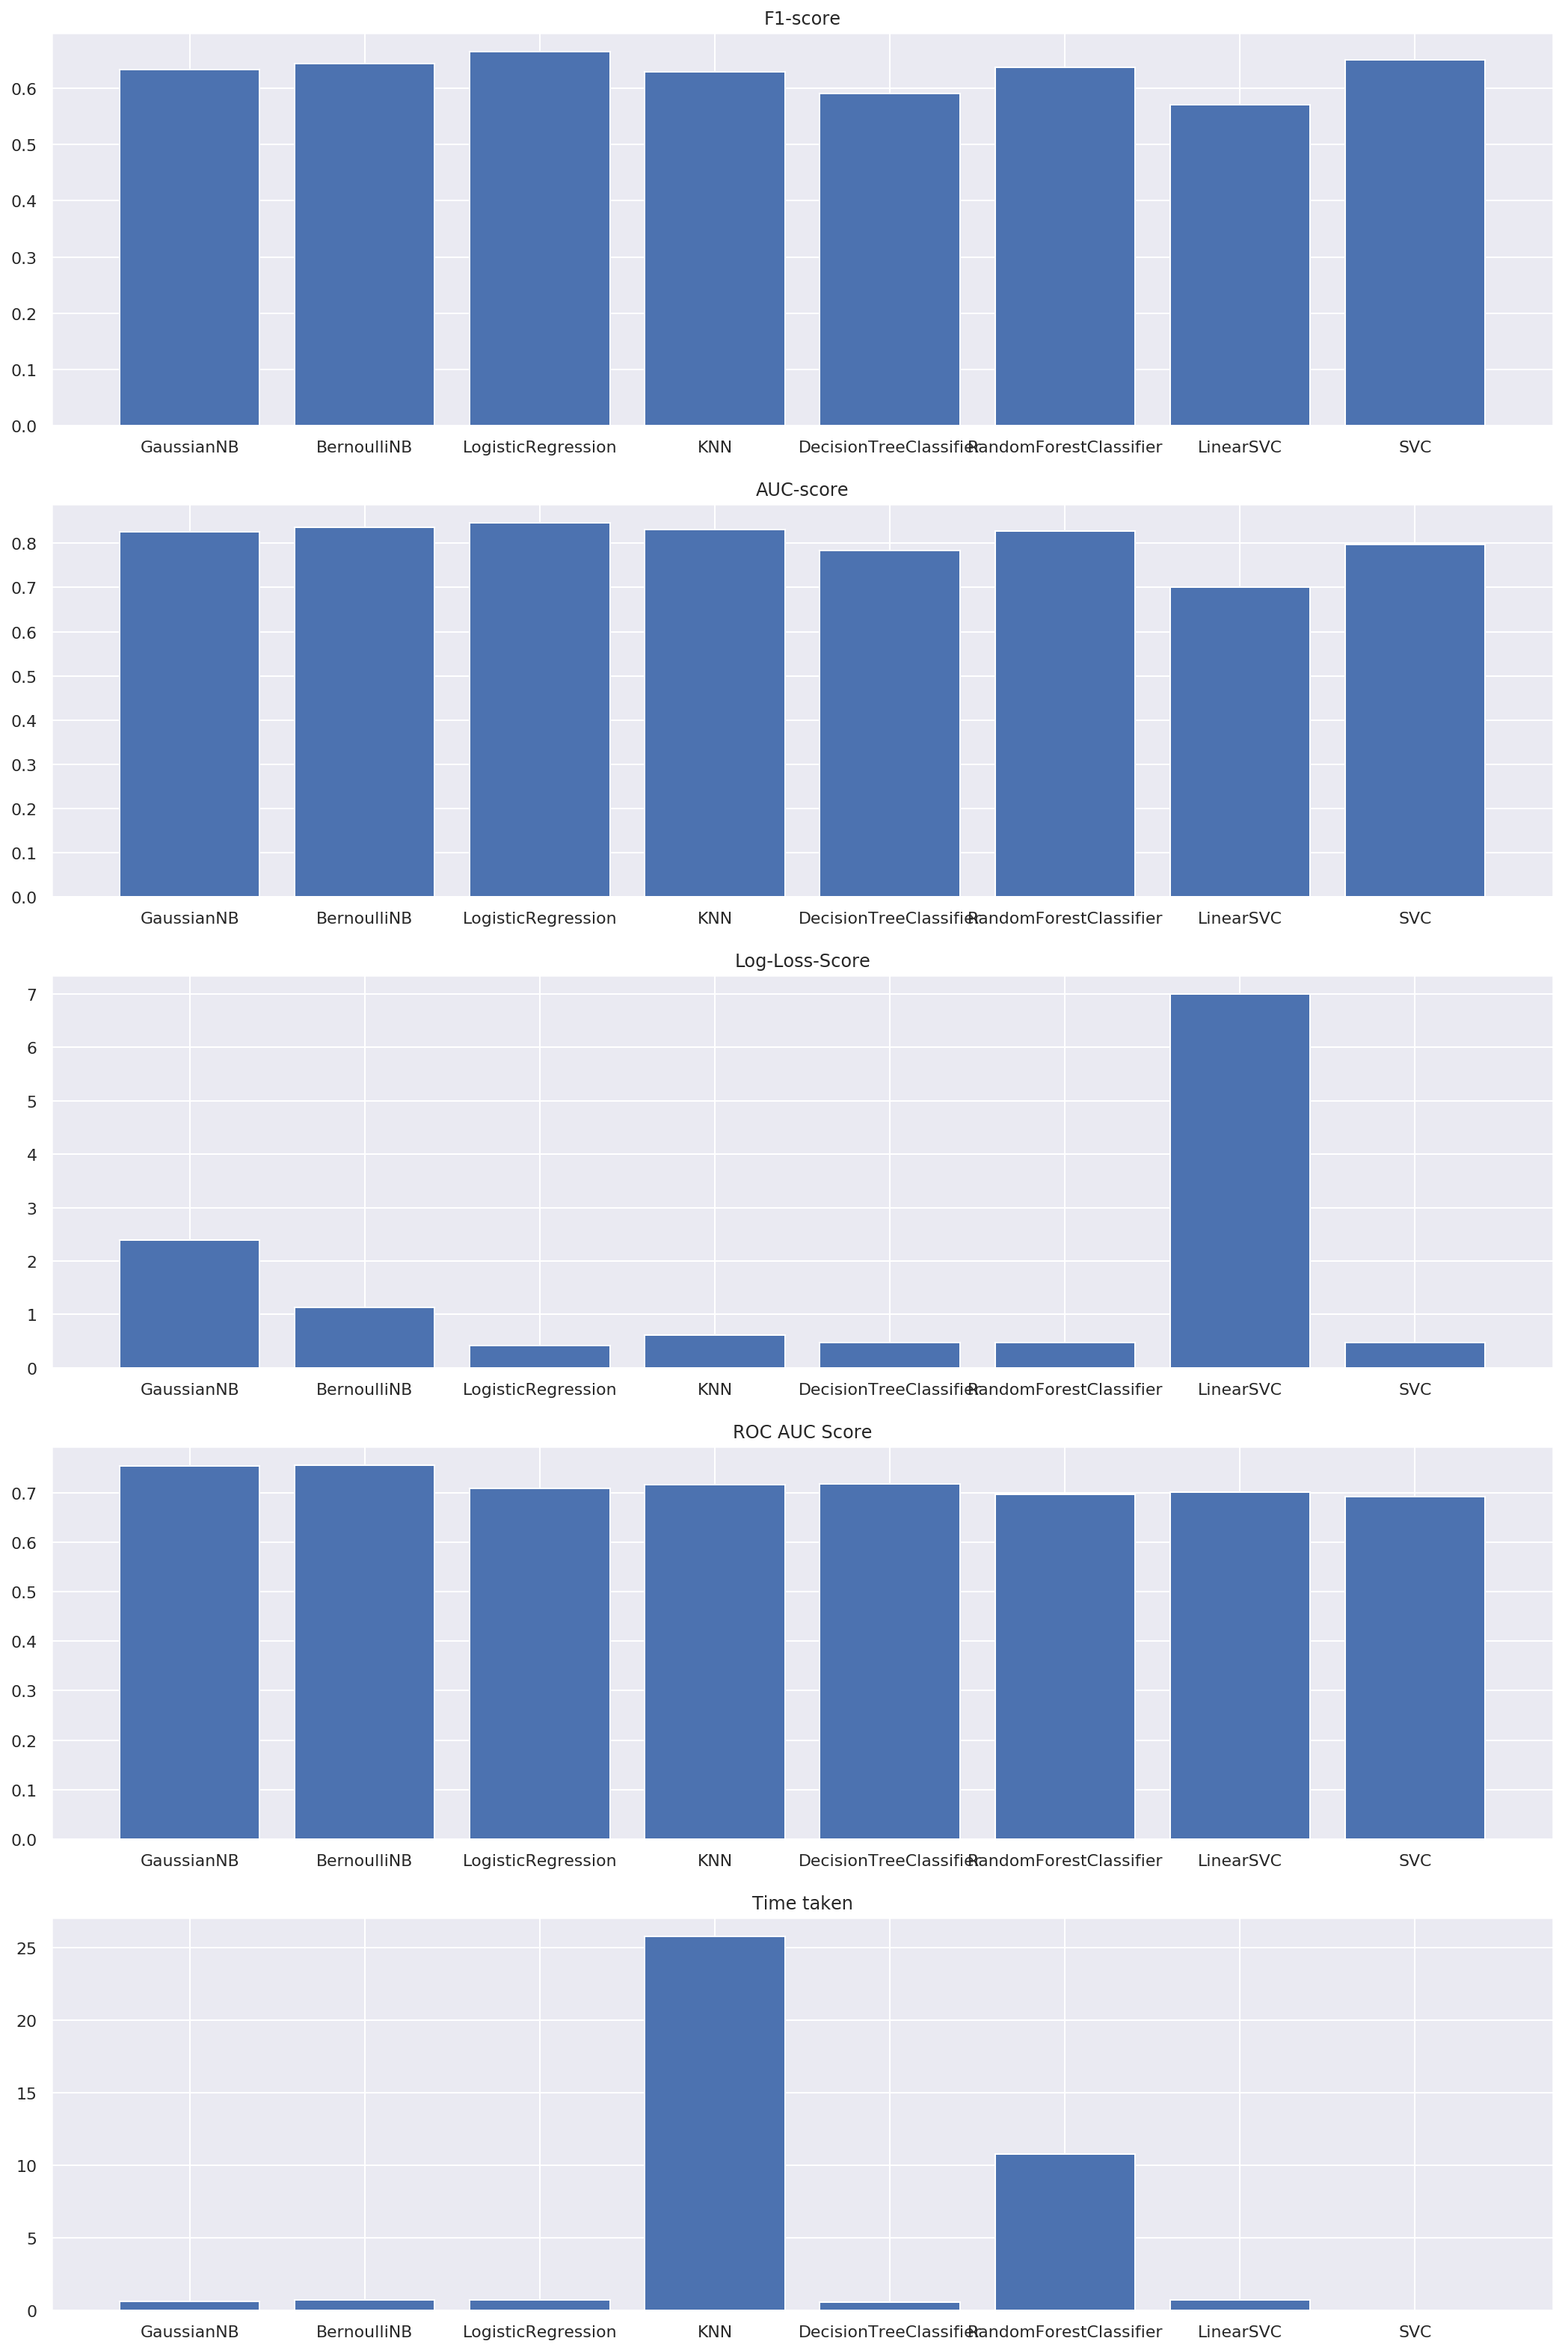

In [53]:
## plot the classification report scores
fig, ax = plt.subplots(5, 1, figsize=(18, 28))
# fig.set_figwidth(10)
# fig.set_figheight(6)
# fig.suptitle('Main Title',fontsize = 16)
ax[0].bar(model_list, f1_list)
ax[0].set_title('F1-score')
ax[1].bar(model_list, auc_list)
ax[1].set_title('AUC-score');
ax[2].bar(model_list, ll_list)
ax[2].set_title('Log-Loss-Score')
ax[3].bar(model_list, roc_auc_list)
ax[3].set_title('ROC AUC Score')
ax[4].bar(model_list, time_list)
ax[4].set_title('Time taken')
# Fine-tune figure; make subplots farther from each other, or nearer to each other.
fig.subplots_adjust(hspace=0.2, wspace=0.2)

**AUC** stands for area under curve, which is explained below. The **ROC** (Receiver Operating Characteristic) curve is a relationship between True Positive Rate and False Positive Rate. Logistic Regression has an area of 0.85 under this curve. It means the model has performed better than random guesses of 0.7, the diagonal line.

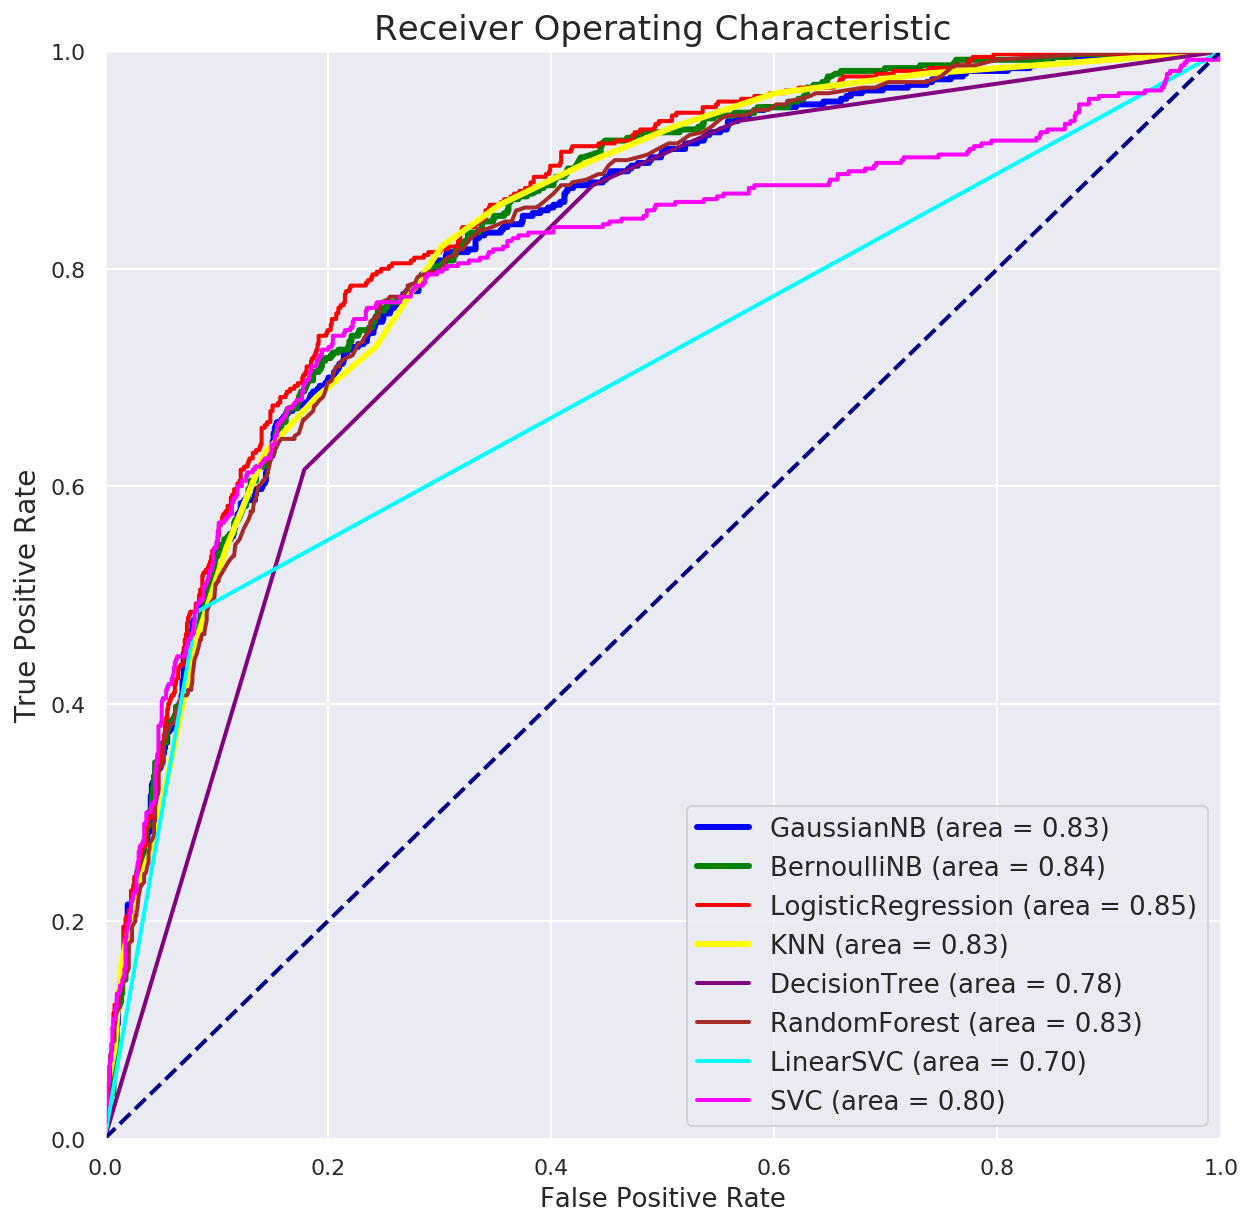

In [54]:
# plot the ROC curves
plt.figure(figsize=(10,10))

y_pred = gnb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='blue',
        lw=3, label='GaussianNB (area = %0.2f)' % auc_list[0])

y_pred = bnb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='green',
        lw=3, label='BernoulliNB (area = %0.2f)' % auc_list[1])

y_pred = logit.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='red',
        lw=2, label='LogisticRegression (area = %0.2f)' % auc_list[2])

y_pred = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='yellow',
        lw=3, label='KNN (area = %0.2f)' % auc_list[3])

y_pred = decisiontree.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='purple',
        lw=2, label='DecisionTree (area = %0.2f)' % auc_list[4])

y_pred = randomforest.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='brown',
        lw=2, label='RandomForest (area = %0.2f)' % auc_list[5])

y_pred = linearsvc.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='cyan',
        lw=2, label='LinearSVC (area = %0.2f)' % auc_list[6])

y_pred = svc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='magenta',
        lw=2, label='SVC (area = %0.2f)' % auc_list[7])

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

For time taken, Logistic Regression may not be the fastest, but it is definitely not the slowest. SVC is 10 times slower than Random Forest Classifier, which is 10 times slower than Logistic Regression.

Another performance metric is **Log-Loss-Score** where we look for the model with the lowest loss function. Once again Logistic Regression is the best, and thus it is the final selected model.

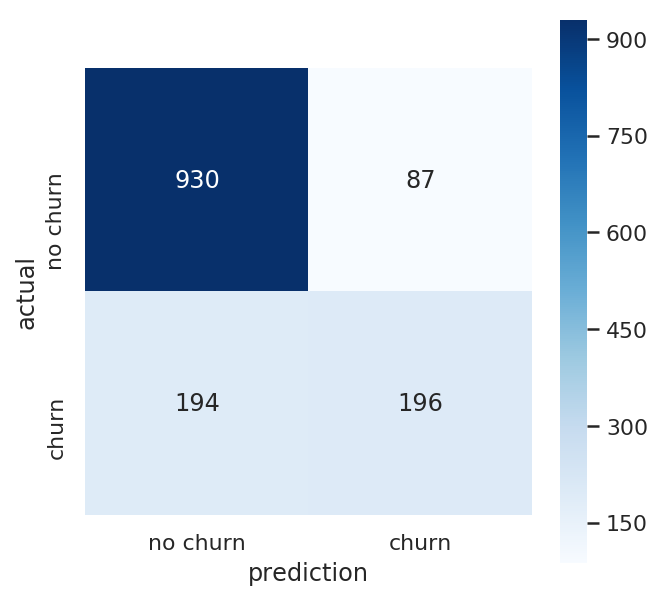

In [57]:
# see how logistic regression confusion matrix varies with threshold
def make_confusion_matrix(model, threshold=0.318):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_pred = (logit.predict_proba(X_test)[:, 1] >= threshold)
    conf = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = [5,5])
    sns.heatmap(conf, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['no churn', 'churn'],
           yticklabels=['no churn', 'churn']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
# Let's see how our confusion matrix changes with changes to the cutoff! 
from ipywidgets import interactive, FloatSlider
logit = LogisticRegression(C = optimal_c)
logit.fit(X_train, y_train)
interactive(lambda threshold: make_confusion_matrix(logit, threshold), threshold=(0.0,1.0,0.01))

Next I tuned the **threshold** of Logistic Regression to maximise the F1-Score. By tuning this hyperparameter, I have achieved the optimised Recall rate of 76%. Recall is defined as the number of churned customers predicted correctly. However, the trade-off is that only 58% of the churn predictions (Precision rate) are correct. This is due to the limitation in the current model and dataset.

In [58]:
# compare above Confusion Matrix with the Optimal threshold 0.318
# Precision: 0.5812,   Recall: 0.7615,   F1 Score: 0.6593
# LogisticRegression confusion matrix: 
#  [[930 87]
#  [ 194 196]]